In [ ]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import time
import random
# For showing images
from IPython.display import Image

import os
import sys

# Load mavenn
import mavenn


In [4]:
# Load and repeat k-fold CV
#df = pd.read_csv('../result/NA_Epi_AA_Bei89.tsv',sep='\t')
from sklearn.utils import shuffle

def LoadData(input,strain):
    df=pd.read_csv(input,sep='\t')
    df=shuffle(df)
    df_strain=df[(df['strain'] ==strain)]
    df_strain['y']= np.log(df_strain['fit'])
    train, test = np.split(df_strain, [int(.8*len(df_strain))]) 
    index = ['val']*int(round(len(train)*0.2)) + ['train']*int(round(len(train)*0.8)) 
    random.shuffle(index)
    train['set']=index
    train = train.reset_index()
    return train, test
def ProduceAA(num,length):
    AA=[]
    AA_ls='ACDEFGHIKLMNPQRSTVWY'
    for i in range(num):
        aa=''.join(random.choice(AA_ls) for x in range(length))
        AA.append(aa)
    AA = pd.Series(AA)
    return AA

def Train_model(train_set,test_set,Random_test_set,reg):
    
    L = len(train_set.iloc[0,1])
    model = mavenn.Model(L=L,
                         alphabet='protein',
                         gpmap_type='pairwise', 
                         regression_type='GE',
                         ge_noise_model_type='Gaussian',
                         eta_regularization=0.1,
                         theta_regularization=reg)
    # Set training data
    model.set_data(x=train_set["ID"],
                   y=train_set["y"],
                   validation_flags=(train_set['set']=='val'),
                   shuffle=True)
    
    # Fit model to data
    history = model.fit(learning_rate=.005,
                        epochs=1000,
                        batch_size=64,
                        early_stopping=True,
                        early_stopping_patience=5,
                        linear_initialization=False)
    x_test = test_set['ID'].values
    y_test = test_set['y'].values
    random_x_test = Random_test_set.values
    # Predict measurement values (yhat) on test data
    yhat_test = model.x_to_yhat(x_test)
    yhat_random_test = model.x_to_yhat(random_x_test)
    y_random_var = np.var(yhat_random_test)
    y_var = np.var(yhat_test)
    # Compute R^2 between yhat and y_test
    Rsq = np.corrcoef(yhat_test.ravel(), y_test)[0, 1]**2
    # Compute likelihood information
    I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
    # Compute predictive information
    I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)

    I_var_hist = model.history['I_var']
    val_I_var_hist = model.history['val_I_var']
    fig, ax = plt.subplots(1,2,figsize=[8,4])
    ax[0].plot(I_var_hist, label='I_var_train')
    ax[0].plot(val_I_var_hist, label='I_var_val')
    ax[0].axhline(I_var, color='C2', linestyle=':', label='I_var_test')
    ax[0].axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
    ax[0].legend()
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('bits')
    ax[0].set_title('training hisotry')
    ax[0].set_ylim([0, I_pred*1.2]);

    ax[1].plot(model.history['loss'])
    ax[1].plot(model.history['val_loss'])
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('$\mathcal{L}_{\text{like}}$')

    plt.tight_layout()
    plt.show()
    return Rsq,y_var, y_random_var

<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0177 sec.
Epoch 1/1000
9/9 [==============================] - 0s 21ms/step - loss: 94.7556 - I_var: -0.0971 - val_loss: 86.7479 - val_I_var: -0.0677
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 90.2812 - I_var: 0.0017 - val_loss: 83.3672 - val_I_var: 0.0016
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 86.2478 - I_var: 0.0642 - val_loss: 80.7812 - val_I_var: 0.0714
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 83.1661 - I_var: 0.1325 - val_loss: 77.8085 - val_I_var: 0.1411
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 80.6366 - I_var: 0.1824 - val_loss: 76.1202 - val_I_var: 0.1775
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 78.1351 - I_var: 0.2115 - val_loss: 74.0708 - val_I_var: 0.2174
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step -

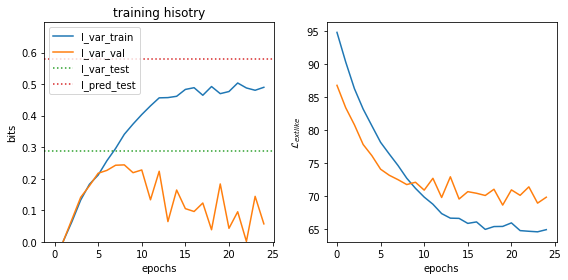

reg is 0.0001
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0202 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 24ms/step - loss: 99.4339 - I_var: -0.2209 - val_loss: 93.8424 - val_I_var: -0.1094
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 92.1039 - I_var: -0.0542 - val_loss: 92.2215 - val_I_var: -0.0799
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 90.0614 - I_var: -0.0336 - val_loss: 90.5387 - val_I_var: -0.0327
Epoch 4/1000
9/9 [==============================] - 0s 7ms/step - loss: 86.3025 - I_var: 0.0692 - val_loss: 89.5413 - val_I_var: 0.0156
Epoch 5/1000
9/9 [==============================] - 0s 7ms/step - loss: 81.3435 - I_var: 0.1667 - val_loss: 86.9125 - val_I_var: 0.0934
Epoch 6/1000
9/9 [==============================] - 0s 7ms/step - loss: 78.5755 - I_var: 0.2416 - val_loss: 83.4263 - val_I_var: 0.1672
Epoch 7/1000
9/9 [==============================] - 0s 7ms/step - loss: 75.4097 - I_var: 0.2947 - val_loss: 83.3749 - val_I_var: 0.1785
Epoch 8/1000
9/9 [==============================] - 0s

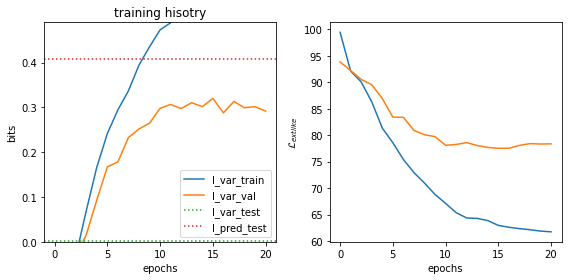

reg is 0.0005
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0172 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 21ms/step - loss: 94.1359 - I_var: -0.0919 - val_loss: 91.0320 - val_I_var: -0.4292
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 89.7531 - I_var: 0.0207 - val_loss: 87.7697 - val_I_var: -0.2980
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 87.1402 - I_var: 0.0791 - val_loss: 83.9767 - val_I_var: -0.1067
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 83.4882 - I_var: 0.1476 - val_loss: 80.3694 - val_I_var: -0.0391
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 80.2308 - I_var: 0.2156 - val_loss: 77.6117 - val_I_var: 0.0346
Epoch 6/1000
9/9 [==============================] - 0s 5ms/step - loss: 77.4154 - I_var: 0.2352 - val_loss: 75.3739 - val_I_var: 0.0938
Epoch 7/1000
9/9 [==============================] - 0s 5ms/step - loss: 76.2006 - I_var: 0.2801 - val_loss: 74.5935 - val_I_var: 0.0671
Epoch 8/1000
9/9 [==============================] - 0s 

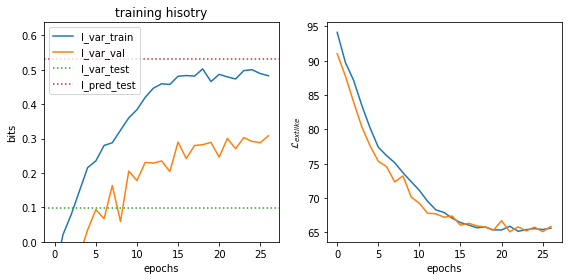

reg is 0.001
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0186 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 23ms/step - loss: 98.8617 - I_var: -0.1810 - val_loss: 88.0000 - val_I_var: -0.0708
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 93.5548 - I_var: -0.0989 - val_loss: 87.6262 - val_I_var: -0.0727
Epoch 3/1000
9/9 [==============================] - 0s 7ms/step - loss: 91.9179 - I_var: -0.0772 - val_loss: 83.3335 - val_I_var: 0.0151
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 89.1867 - I_var: -0.0102 - val_loss: 80.3202 - val_I_var: 0.1186
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 84.6220 - I_var: 0.0918 - val_loss: 77.6111 - val_I_var: 0.1968
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 80.3771 - I_var: 0.1705 - val_loss: 74.7424 - val_I_var: 0.2334
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 78.1398 - I_var: 0.2369 - val_loss: 73.2525 - val_I_var: 0.2402
Epoch 8/1000
9/9 [==============================] - 0s

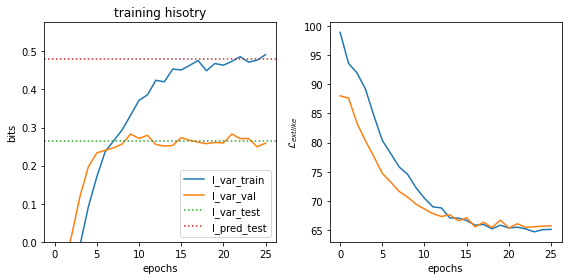

reg is 0.005
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0176 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 20ms/step - loss: 100.3758 - I_var: -0.1891 - val_loss: 84.2219 - val_I_var: 0.1254
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 94.8907 - I_var: -0.0992 - val_loss: 82.5277 - val_I_var: 0.1449
Epoch 3/1000
9/9 [==============================] - 0s 7ms/step - loss: 92.4088 - I_var: -0.0532 - val_loss: 78.5709 - val_I_var: 0.2144
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 88.0008 - I_var: 0.0321 - val_loss: 75.8321 - val_I_var: 0.2635
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 83.6524 - I_var: 0.1378 - val_loss: 74.7369 - val_I_var: 0.2835
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 79.8103 - I_var: 0.1963 - val_loss: 73.4964 - val_I_var: 0.3195
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 77.7104 - I_var: 0.2427 - val_loss: 72.4202 - val_I_var: 0.3384
Epoch 8/1000
9/9 [==============================] - 0s 6

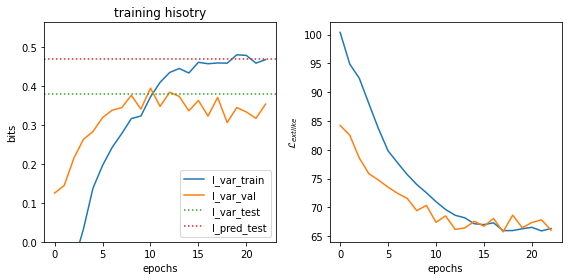

reg is 0.01
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0161 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 20ms/step - loss: 103.8602 - I_var: -0.1307 - val_loss: 94.2066 - val_I_var: 0.0608
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 96.6243 - I_var: -0.0382 - val_loss: 90.0119 - val_I_var: 0.0959
Epoch 3/1000
9/9 [==============================] - 0s 5ms/step - loss: 90.9613 - I_var: 0.0366 - val_loss: 87.0822 - val_I_var: 0.1105
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 85.4060 - I_var: 0.1338 - val_loss: 82.1035 - val_I_var: 0.2203
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 81.8174 - I_var: 0.1934 - val_loss: 80.1219 - val_I_var: 0.2535
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 78.8191 - I_var: 0.2371 - val_loss: 78.3026 - val_I_var: 0.2813
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 76.7855 - I_var: 0.2917 - val_loss: 77.2046 - val_I_var: 0.3079
Epoch 8/1000
9/9 [==============================] - 0s 6m

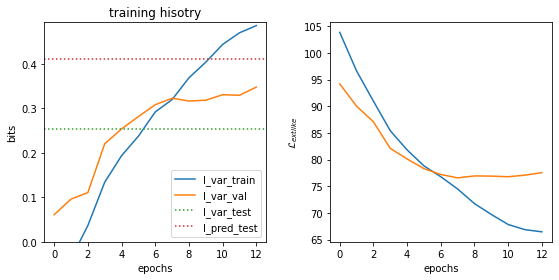

reg is 0.05
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.016 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 20ms/step - loss: 109.7127 - I_var: -0.0502 - val_loss: 102.7277 - val_I_var: -0.1526
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 98.9599 - I_var: 0.0496 - val_loss: 93.5579 - val_I_var: -0.0227
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 90.9991 - I_var: 0.1454 - val_loss: 87.0714 - val_I_var: 0.1134
Epoch 4/1000
9/9 [==============================] - 0s 5ms/step - loss: 85.4973 - I_var: 0.2126 - val_loss: 84.2112 - val_I_var: 0.1245
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 81.6054 - I_var: 0.2502 - val_loss: 81.9422 - val_I_var: 0.1608
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 79.3912 - I_var: 0.3094 - val_loss: 80.2243 - val_I_var: 0.1926
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 76.6395 - I_var: 0.3211 - val_loss: 78.9295 - val_I_var: 0.2220
Epoch 8/1000
9/9 [==============================] - 0s 

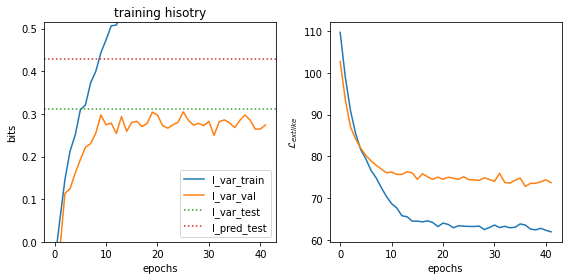

reg is 0.1
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0179 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 19ms/step - loss: 145.7539 - I_var: -0.1711 - val_loss: 119.7059 - val_I_var: 0.1409
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 123.1227 - I_var: -0.0389 - val_loss: 105.6759 - val_I_var: 0.1418
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 110.2081 - I_var: -0.0151 - val_loss: 95.4888 - val_I_var: 0.1979
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 99.3351 - I_var: 0.0836 - val_loss: 89.1361 - val_I_var: 0.2396
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 90.9413 - I_var: 0.1717 - val_loss: 82.4840 - val_I_var: 0.3204
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 84.9547 - I_var: 0.2523 - val_loss: 79.3362 - val_I_var: 0.3463
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 80.9318 - I_var: 0.2973 - val_loss: 75.3879 - val_I_var: 0.4035
Epoch 8/1000
9/9 [==============================] - 

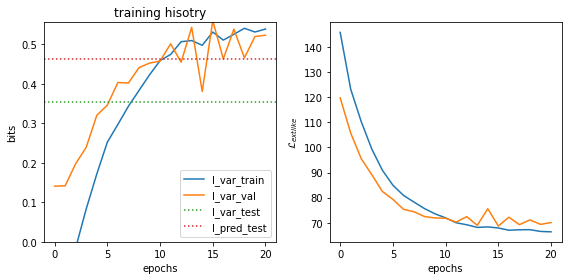

reg is 0.3
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0176 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 19ms/step - loss: 180.7227 - I_var: -0.2890 - val_loss: 145.8437 - val_I_var: 0.0550
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 143.5468 - I_var: -0.1576 - val_loss: 122.9067 - val_I_var: 0.0545
Epoch 3/1000
9/9 [==============================] - 0s 5ms/step - loss: 124.0478 - I_var: -0.1410 - val_loss: 107.5815 - val_I_var: 0.0629
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 110.7524 - I_var: -0.0878 - val_loss: 97.7645 - val_I_var: 0.0811
Epoch 5/1000
9/9 [==============================] - 0s 5ms/step - loss: 100.5873 - I_var: -0.0224 - val_loss: 90.9511 - val_I_var: 0.1303
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 92.4426 - I_var: 0.0881 - val_loss: 85.8354 - val_I_var: 0.1821
Epoch 7/1000
9/9 [==============================] - 0s 5ms/step - loss: 86.2569 - I_var: 0.1527 - val_loss: 81.9188 - val_I_var: 0.2425
Epoch 8/1000
9/9 [=============================

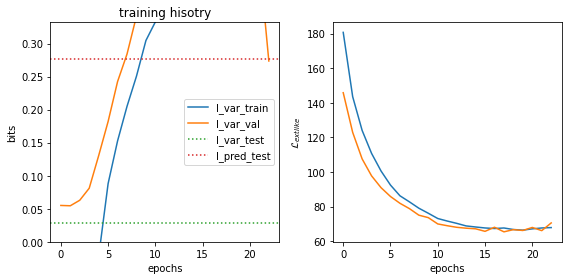

reg is 0.5
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0169 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 19ms/step - loss: 223.4985 - I_var: -0.1315 - val_loss: 180.8747 - val_I_var: 0.2050
Epoch 2/1000
9/9 [==============================] - 0s 5ms/step - loss: 169.1087 - I_var: -0.0213 - val_loss: 142.2990 - val_I_var: 0.2399
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 135.6941 - I_var: 0.0815 - val_loss: 118.2044 - val_I_var: 0.2330
Epoch 4/1000
9/9 [==============================] - 0s 5ms/step - loss: 114.2004 - I_var: 0.1540 - val_loss: 101.4814 - val_I_var: 0.3128
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 100.4786 - I_var: 0.2299 - val_loss: 92.2672 - val_I_var: 0.3336
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 91.3603 - I_var: 0.2808 - val_loss: 86.6940 - val_I_var: 0.3362
Epoch 7/1000
9/9 [==============================] - 0s 5ms/step - loss: 85.6288 - I_var: 0.3233 - val_loss: 82.5616 - val_I_var: 0.3402
Epoch 8/1000
9/9 [==============================]

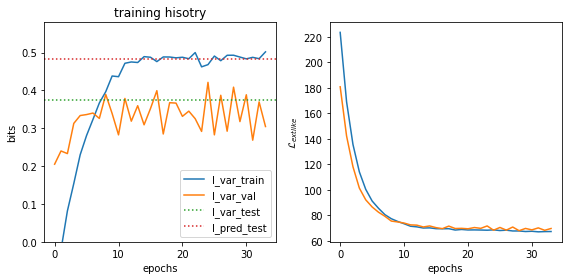

reg is 0.8
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0158 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 19ms/step - loss: 254.6664 - I_var: -0.1736 - val_loss: 206.5211 - val_I_var: -0.0656
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 189.4716 - I_var: -0.0604 - val_loss: 160.0754 - val_I_var: -0.0518
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 150.2089 - I_var: -0.0095 - val_loss: 128.6478 - val_I_var: 0.1002
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 124.3497 - I_var: 0.0674 - val_loss: 110.1388 - val_I_var: 0.1364
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 108.3092 - I_var: 0.1403 - val_loss: 98.6734 - val_I_var: 0.1645
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 97.5503 - I_var: 0.1850 - val_loss: 91.3347 - val_I_var: 0.1989
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 90.8885 - I_var: 0.2292 - val_loss: 86.3783 - val_I_var: 0.1952
Epoch 8/1000
9/9 [============================

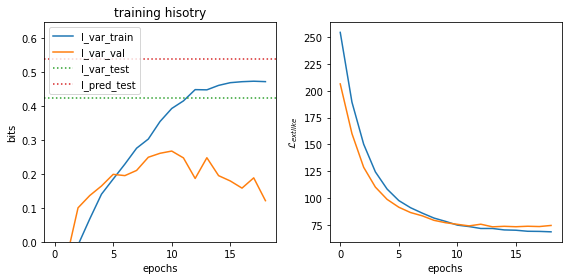

reg is 1
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0169 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 19ms/step - loss: 344.3653 - I_var: -0.2112 - val_loss: 271.9819 - val_I_var: -0.0120
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 245.6652 - I_var: -0.0152 - val_loss: 202.3699 - val_I_var: 0.0116
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 187.9437 - I_var: 0.0040 - val_loss: 157.9171 - val_I_var: 0.0708
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 149.8820 - I_var: 0.0711 - val_loss: 130.4982 - val_I_var: 0.1662
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 124.9641 - I_var: 0.1702 - val_loss: 113.8006 - val_I_var: 0.2322
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 109.8297 - I_var: 0.2454 - val_loss: 102.8091 - val_I_var: 0.2624
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 99.7313 - I_var: 0.2858 - val_loss: 95.4923 - val_I_var: 0.2795
Epoch 8/1000
9/9 [===========================

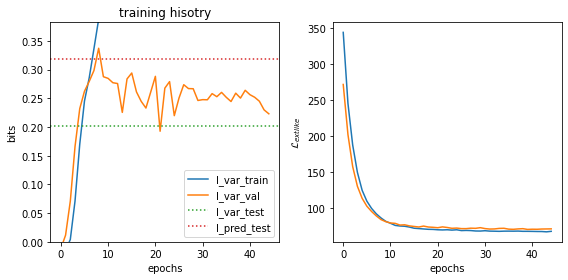

reg is 1.5
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0163 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 19ms/step - loss: 412.8663 - I_var: -0.1609 - val_loss: 327.1446 - val_I_var: -0.1196
Epoch 2/1000
9/9 [==============================] - 0s 5ms/step - loss: 285.8919 - I_var: -0.0172 - val_loss: 235.4475 - val_I_var: -0.0887
Epoch 3/1000
9/9 [==============================] - 0s 5ms/step - loss: 210.0865 - I_var: 0.0254 - val_loss: 177.6991 - val_I_var: -0.0545
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 162.5571 - I_var: 0.1084 - val_loss: 140.5239 - val_I_var: 0.0679
Epoch 5/1000
9/9 [==============================] - 0s 5ms/step - loss: 131.9179 - I_var: 0.1825 - val_loss: 116.4431 - val_I_var: 0.1957
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 113.5069 - I_var: 0.2375 - val_loss: 101.6837 - val_I_var: 0.2702
Epoch 7/1000
9/9 [==============================] - 0s 5ms/step - loss: 101.8148 - I_var: 0.2874 - val_loss: 92.1627 - val_I_var: 0.3161
Epoch 8/1000
9/9 [========================

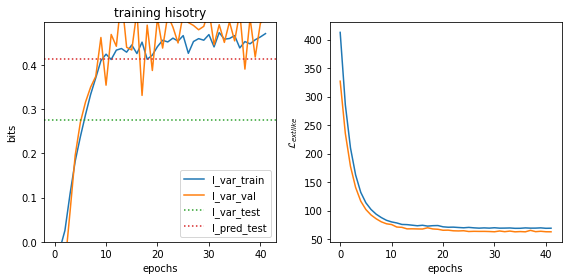

reg is 2
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0196 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 44ms/step - loss: 94.7877 - I_var: -0.0941 - val_loss: 96.0036 - val_I_var: -0.1760
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 90.9701 - I_var: -0.0322 - val_loss: 94.6945 - val_I_var: -0.1502
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 88.6024 - I_var: 0.0052 - val_loss: 89.1752 - val_I_var: 0.0031
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 85.4633 - I_var: 0.0757 - val_loss: 84.1420 - val_I_var: 0.1069
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 81.5108 - I_var: 0.1547 - val_loss: 81.0491 - val_I_var: 0.1573
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 79.2390 - I_var: 0.2181 - val_loss: 79.3396 - val_I_var: 0.1865
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 77.2587 - I_var: 0.2454 - val_loss: 78.2286 - val_I_var: 0.2059
Epoch 8/1000
9/9 [==============================] - 0s 6

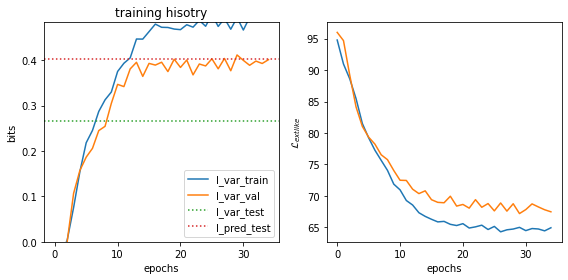

reg is 0.0001
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0191 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 21ms/step - loss: 97.8953 - I_var: -0.2042 - val_loss: 89.9146 - val_I_var: -0.1145
Epoch 2/1000
9/9 [==============================] - 0s 5ms/step - loss: 92.7309 - I_var: -0.0571 - val_loss: 89.6003 - val_I_var: -0.1077
Epoch 3/1000
9/9 [==============================] - 0s 5ms/step - loss: 91.2786 - I_var: -0.0385 - val_loss: 86.9227 - val_I_var: -0.0918
Epoch 4/1000
9/9 [==============================] - 0s 5ms/step - loss: 88.6637 - I_var: 0.0109 - val_loss: 83.3850 - val_I_var: -0.0529
Epoch 5/1000
9/9 [==============================] - 0s 5ms/step - loss: 84.3570 - I_var: 0.1046 - val_loss: 79.9127 - val_I_var: 0.0437
Epoch 6/1000
9/9 [==============================] - 0s 5ms/step - loss: 80.7618 - I_var: 0.1785 - val_loss: 78.8055 - val_I_var: 0.0576
Epoch 7/1000
9/9 [==============================] - 0s 5ms/step - loss: 78.5391 - I_var: 0.2303 - val_loss: 77.0110 - val_I_var: 0.1153
Epoch 8/1000
9/9 [==============================] - 0

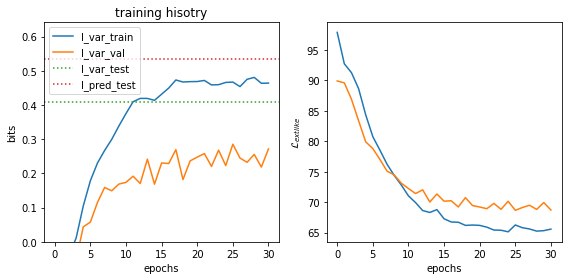

reg is 0.0005
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0177 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 19ms/step - loss: 97.3591 - I_var: -0.1474 - val_loss: 97.4699 - val_I_var: -0.3108
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 89.6128 - I_var: 0.0132 - val_loss: 96.1957 - val_I_var: -0.2996
Epoch 3/1000
9/9 [==============================] - 0s 5ms/step - loss: 87.2595 - I_var: 0.0487 - val_loss: 91.8927 - val_I_var: -0.1526
Epoch 4/1000
9/9 [==============================] - 0s 5ms/step - loss: 84.2950 - I_var: 0.1210 - val_loss: 86.7714 - val_I_var: -0.0366
Epoch 5/1000
9/9 [==============================] - 0s 5ms/step - loss: 80.0432 - I_var: 0.2089 - val_loss: 82.8963 - val_I_var: 0.0261
Epoch 6/1000
9/9 [==============================] - 0s 5ms/step - loss: 76.6786 - I_var: 0.2662 - val_loss: 79.0384 - val_I_var: 0.1092
Epoch 7/1000
9/9 [==============================] - 0s 5ms/step - loss: 75.1835 - I_var: 0.3146 - val_loss: 78.8232 - val_I_var: 0.0719
Epoch 8/1000
9/9 [==============================] - 0s 

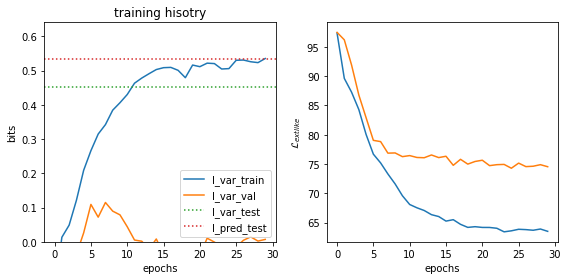

reg is 0.001
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.019 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 22ms/step - loss: 93.9594 - I_var: -0.0741 - val_loss: 91.9712 - val_I_var: -0.5607
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 89.1723 - I_var: 0.0286 - val_loss: 87.9932 - val_I_var: -0.4204
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 85.3237 - I_var: 0.1176 - val_loss: 82.7241 - val_I_var: -0.3061
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 80.7703 - I_var: 0.1857 - val_loss: 80.3204 - val_I_var: -0.2906
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 78.5756 - I_var: 0.2367 - val_loss: 79.7031 - val_I_var: -0.2902
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 76.5980 - I_var: 0.2679 - val_loss: 78.2662 - val_I_var: -0.3116
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 74.8935 - I_var: 0.2771 - val_loss: 76.3794 - val_I_var: -0.3042
Epoch 8/1000
9/9 [==============================] - 

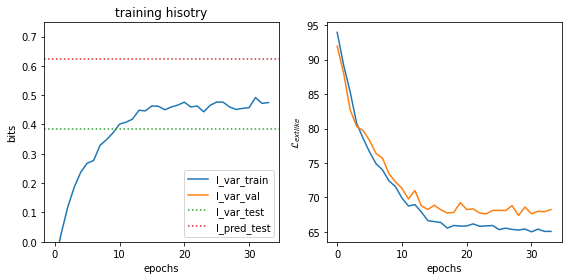

reg is 0.005
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0174 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 26ms/step - loss: 96.3284 - I_var: -0.0780 - val_loss: 91.9733 - val_I_var: 0.0062
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 92.6497 - I_var: -0.0182 - val_loss: 88.6018 - val_I_var: 0.0633
Epoch 3/1000
9/9 [==============================] - 0s 8ms/step - loss: 89.4885 - I_var: 0.0534 - val_loss: 81.9625 - val_I_var: 0.1651
Epoch 4/1000
9/9 [==============================] - 0s 7ms/step - loss: 86.3168 - I_var: 0.1126 - val_loss: 78.8834 - val_I_var: 0.2235
Epoch 5/1000
9/9 [==============================] - 0s 7ms/step - loss: 83.5284 - I_var: 0.1793 - val_loss: 76.1061 - val_I_var: 0.2684
Epoch 6/1000
9/9 [==============================] - 0s 7ms/step - loss: 81.3266 - I_var: 0.2158 - val_loss: 74.2352 - val_I_var: 0.3088
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 79.5436 - I_var: 0.2533 - val_loss: 73.0575 - val_I_var: 0.3444
Epoch 8/1000
9/9 [==============================] - 0s 7ms

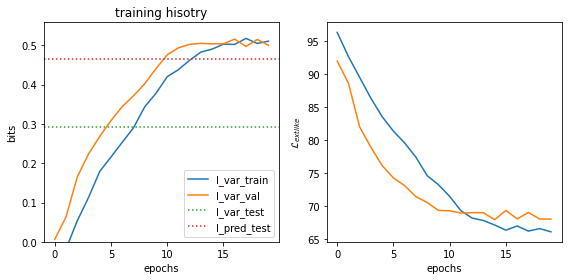

reg is 0.01
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0165 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 20ms/step - loss: 110.2874 - I_var: -0.2778 - val_loss: 96.1915 - val_I_var: -0.0330
Epoch 2/1000
9/9 [==============================] - 0s 5ms/step - loss: 98.8422 - I_var: -0.0873 - val_loss: 93.1239 - val_I_var: -0.0143
Epoch 3/1000
9/9 [==============================] - 0s 5ms/step - loss: 96.1129 - I_var: -0.0968 - val_loss: 91.3045 - val_I_var: -0.0102
Epoch 4/1000
9/9 [==============================] - 0s 5ms/step - loss: 94.7657 - I_var: -0.0852 - val_loss: 89.5953 - val_I_var: -0.0066
Epoch 5/1000
9/9 [==============================] - 0s 5ms/step - loss: 93.2804 - I_var: -0.0724 - val_loss: 88.1789 - val_I_var: -3.2647e-04
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 91.2932 - I_var: -0.0494 - val_loss: 86.3893 - val_I_var: 0.0229
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 87.7385 - I_var: 0.0272 - val_loss: 84.3516 - val_I_var: 0.0653
Epoch 8/1000
9/9 [==========================

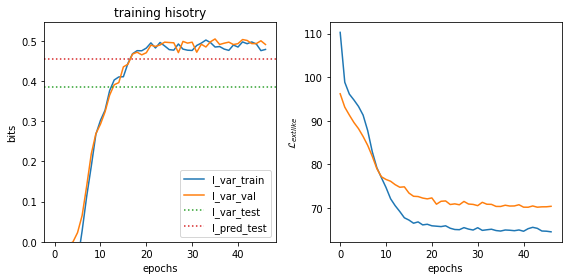

reg is 0.05
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0175 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 20ms/step - loss: 109.5368 - I_var: -0.0354 - val_loss: 99.5931 - val_I_var: 0.0020
Epoch 2/1000
9/9 [==============================] - 0s 5ms/step - loss: 100.0417 - I_var: 0.0219 - val_loss: 90.1881 - val_I_var: 0.0952
Epoch 3/1000
9/9 [==============================] - 0s 5ms/step - loss: 92.7025 - I_var: 0.1185 - val_loss: 83.1256 - val_I_var: 0.1998
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 86.4451 - I_var: 0.1986 - val_loss: 78.7885 - val_I_var: 0.2548
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 81.8968 - I_var: 0.2399 - val_loss: 75.9007 - val_I_var: 0.2773
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 80.3491 - I_var: 0.2895 - val_loss: 73.9304 - val_I_var: 0.2950
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 77.5650 - I_var: 0.3160 - val_loss: 72.2819 - val_I_var: 0.2839
Epoch 8/1000
9/9 [==============================] - 0s 6m

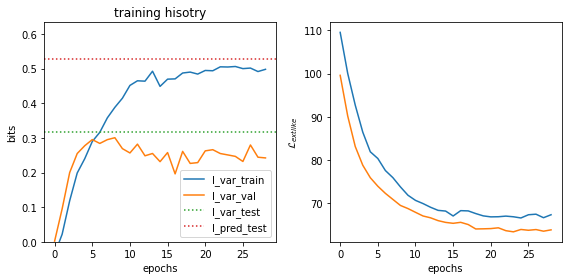

reg is 0.1
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0192 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 21ms/step - loss: 140.6012 - I_var: -0.0770 - val_loss: 132.6821 - val_I_var: -0.1345
Epoch 2/1000
9/9 [==============================] - 0s 5ms/step - loss: 117.1688 - I_var: 0.0112 - val_loss: 116.0534 - val_I_var: -0.0719
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 103.0189 - I_var: 0.0847 - val_loss: 103.0432 - val_I_var: 0.0128
Epoch 4/1000
9/9 [==============================] - 0s 5ms/step - loss: 92.7044 - I_var: 0.1781 - val_loss: 96.3094 - val_I_var: 0.0654
Epoch 5/1000
9/9 [==============================] - 0s 5ms/step - loss: 86.5245 - I_var: 0.2453 - val_loss: 89.5800 - val_I_var: 0.1458
Epoch 6/1000
9/9 [==============================] - 0s 5ms/step - loss: 81.9723 - I_var: 0.2891 - val_loss: 87.5994 - val_I_var: 0.1588
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 78.1873 - I_var: 0.3226 - val_loss: 84.3079 - val_I_var: 0.2115
Epoch 8/1000
9/9 [==============================] -

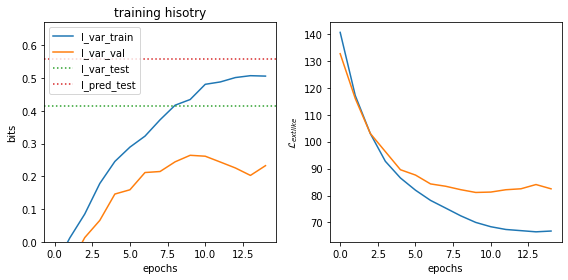

reg is 0.3
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0168 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 20ms/step - loss: 175.0115 - I_var: -0.1631 - val_loss: 139.9095 - val_I_var: 0.0415
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 141.7319 - I_var: -0.0978 - val_loss: 116.9188 - val_I_var: 0.0382
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 121.2571 - I_var: -0.0382 - val_loss: 104.1103 - val_I_var: -0.0134
Epoch 4/1000
9/9 [==============================] - 0s 5ms/step - loss: 107.3537 - I_var: 0.0122 - val_loss: 92.9564 - val_I_var: 0.0671
Epoch 5/1000
9/9 [==============================] - 0s 5ms/step - loss: 97.8582 - I_var: 0.0659 - val_loss: 87.1169 - val_I_var: 0.0835
Epoch 6/1000
9/9 [==============================] - 0s 5ms/step - loss: 91.0376 - I_var: 0.1448 - val_loss: 81.6594 - val_I_var: 0.1437
Epoch 7/1000
9/9 [==============================] - 0s 5ms/step - loss: 86.0974 - I_var: 0.2043 - val_loss: 78.5840 - val_I_var: 0.1614
Epoch 8/1000
9/9 [==============================]

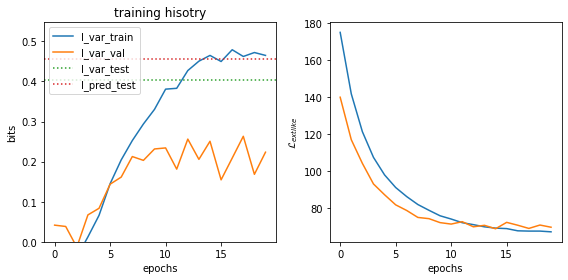

reg is 0.5
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0163 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 22ms/step - loss: 215.4620 - I_var: -0.0726 - val_loss: 182.6527 - val_I_var: -0.0907
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 165.5813 - I_var: -0.0056 - val_loss: 143.4864 - val_I_var: -0.0401
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 132.9315 - I_var: 0.0792 - val_loss: 116.2506 - val_I_var: 0.0845
Epoch 4/1000
9/9 [==============================] - 0s 5ms/step - loss: 111.2743 - I_var: 0.1521 - val_loss: 99.6791 - val_I_var: 0.2017
Epoch 5/1000
9/9 [==============================] - 0s 5ms/step - loss: 98.4661 - I_var: 0.2266 - val_loss: 90.5051 - val_I_var: 0.2342
Epoch 6/1000
9/9 [==============================] - 0s 5ms/step - loss: 89.9763 - I_var: 0.2744 - val_loss: 84.9044 - val_I_var: 0.2527
Epoch 7/1000
9/9 [==============================] - 0s 5ms/step - loss: 83.9032 - I_var: 0.3140 - val_loss: 79.9136 - val_I_var: 0.2805
Epoch 8/1000
9/9 [==============================]

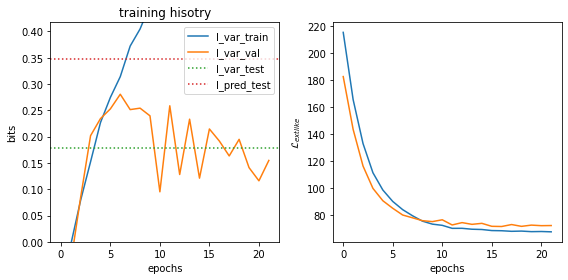

reg is 0.8
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.019 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 19ms/step - loss: 257.4463 - I_var: -0.2108 - val_loss: 214.5462 - val_I_var: -0.1560
Epoch 2/1000
9/9 [==============================] - 0s 5ms/step - loss: 191.4633 - I_var: -0.1006 - val_loss: 168.4762 - val_I_var: -0.1360
Epoch 3/1000
9/9 [==============================] - 0s 5ms/step - loss: 152.6778 - I_var: -0.0389 - val_loss: 136.7911 - val_I_var: -0.0334
Epoch 4/1000
9/9 [==============================] - 0s 5ms/step - loss: 126.4451 - I_var: 0.0477 - val_loss: 115.5931 - val_I_var: 0.0904
Epoch 5/1000
9/9 [==============================] - 0s 5ms/step - loss: 108.8898 - I_var: 0.1318 - val_loss: 101.8664 - val_I_var: 0.1881
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 98.1971 - I_var: 0.1914 - val_loss: 93.8049 - val_I_var: 0.2316
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 91.0039 - I_var: 0.2312 - val_loss: 88.7858 - val_I_var: 0.2689
Epoch 8/1000
9/9 [==========================

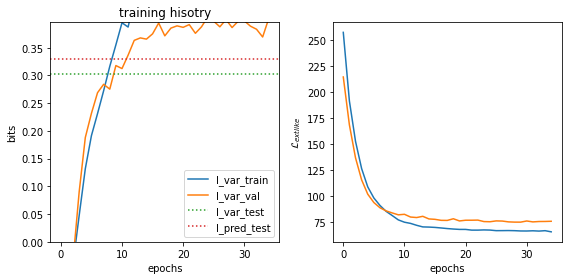

reg is 1
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0186 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 20ms/step - loss: 339.4890 - I_var: -0.1035 - val_loss: 278.8706 - val_I_var: -0.0059
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 243.9335 - I_var: -0.0387 - val_loss: 208.4598 - val_I_var: 0.0149
Epoch 3/1000
9/9 [==============================] - 0s 5ms/step - loss: 184.6522 - I_var: 0.0209 - val_loss: 163.8914 - val_I_var: 0.0627
Epoch 4/1000
9/9 [==============================] - 0s 5ms/step - loss: 146.5477 - I_var: 0.1033 - val_loss: 132.5182 - val_I_var: 0.1744
Epoch 5/1000
9/9 [==============================] - 0s 5ms/step - loss: 122.4907 - I_var: 0.1855 - val_loss: 113.9976 - val_I_var: 0.2176
Epoch 6/1000
9/9 [==============================] - 0s 5ms/step - loss: 107.4237 - I_var: 0.2360 - val_loss: 102.2378 - val_I_var: 0.2593
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 97.2012 - I_var: 0.2962 - val_loss: 95.6789 - val_I_var: 0.2787
Epoch 8/1000
9/9 [===========================

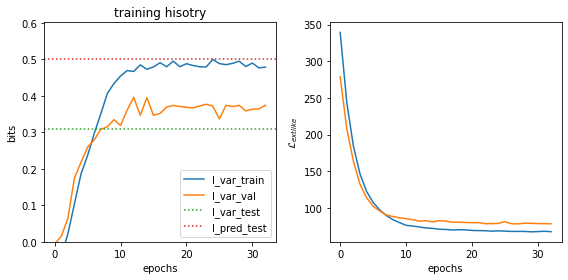

reg is 1.5
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0176 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 23ms/step - loss: 427.8731 - I_var: -0.0925 - val_loss: 338.7816 - val_I_var: 0.1209
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 300.6068 - I_var: 0.0051 - val_loss: 243.8067 - val_I_var: 0.0978
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 219.9485 - I_var: 0.0805 - val_loss: 183.2628 - val_I_var: 0.1641
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 169.4690 - I_var: 0.1792 - val_loss: 145.6226 - val_I_var: 0.2103
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 137.9713 - I_var: 0.2233 - val_loss: 121.8777 - val_I_var: 0.2682
Epoch 6/1000
9/9 [==============================] - 0s 5ms/step - loss: 117.5996 - I_var: 0.2721 - val_loss: 106.5187 - val_I_var: 0.2955
Epoch 7/1000
9/9 [==============================] - 0s 5ms/step - loss: 103.5629 - I_var: 0.3271 - val_loss: 96.6525 - val_I_var: 0.3242
Epoch 8/1000
9/9 [============================

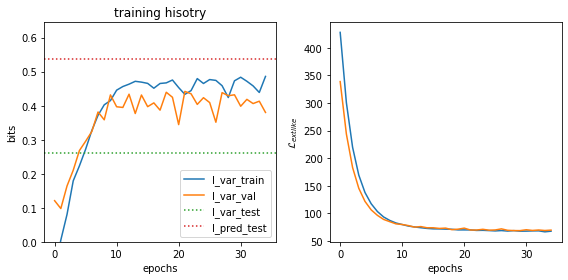

reg is 2
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0174 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 29ms/step - loss: 97.8718 - I_var: -0.1856 - val_loss: 91.9303 - val_I_var: -0.1944
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 90.7156 - I_var: -0.0717 - val_loss: 91.1417 - val_I_var: -0.1878
Epoch 3/1000
9/9 [==============================] - 0s 7ms/step - loss: 88.8400 - I_var: -0.0187 - val_loss: 86.8703 - val_I_var: -0.0165
Epoch 4/1000
9/9 [==============================] - 0s 7ms/step - loss: 85.2826 - I_var: 0.0673 - val_loss: 83.6436 - val_I_var: 0.0793
Epoch 5/1000
9/9 [==============================] - 0s 7ms/step - loss: 81.3755 - I_var: 0.1559 - val_loss: 81.2829 - val_I_var: 0.1148
Epoch 6/1000
9/9 [==============================] - 0s 7ms/step - loss: 78.6311 - I_var: 0.2135 - val_loss: 79.9796 - val_I_var: 0.1540
Epoch 7/1000
9/9 [==============================] - 0s 7ms/step - loss: 76.5277 - I_var: 0.2571 - val_loss: 78.7143 - val_I_var: 0.1833
Epoch 8/1000
9/9 [==============================] - 0s

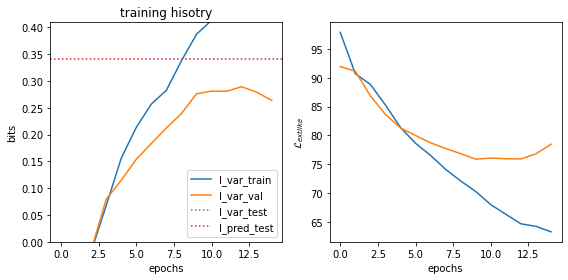

reg is 0.0001
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0176 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 23ms/step - loss: 104.4173 - I_var: -0.3092 - val_loss: 88.5650 - val_I_var: -0.0336
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 94.6498 - I_var: -0.0892 - val_loss: 86.6872 - val_I_var: 0.0156
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 93.7760 - I_var: -0.0700 - val_loss: 86.1542 - val_I_var: 0.0223
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 92.6549 - I_var: -0.0879 - val_loss: 85.7525 - val_I_var: 0.0250
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 93.0268 - I_var: -0.0650 - val_loss: 85.4078 - val_I_var: 0.0236
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 92.5608 - I_var: -0.0628 - val_loss: 85.0760 - val_I_var: 0.0086
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 91.7069 - I_var: -0.0639 - val_loss: 84.4873 - val_I_var: 5.0775e-04
Epoch 8/1000
9/9 [=============================

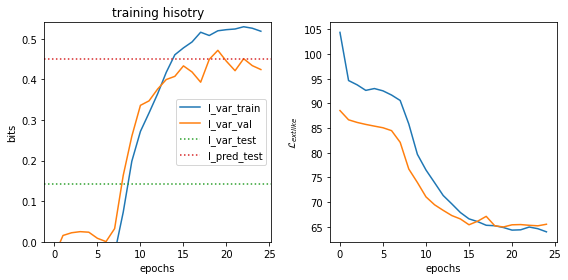

reg is 0.0005
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0212 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 22ms/step - loss: 95.9751 - I_var: -0.1211 - val_loss: 89.1892 - val_I_var: -0.1238
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 89.7794 - I_var: -0.0028 - val_loss: 86.9134 - val_I_var: -0.0751
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 86.0904 - I_var: 0.0810 - val_loss: 84.4452 - val_I_var: -0.0104
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 82.7200 - I_var: 0.1547 - val_loss: 81.7631 - val_I_var: 0.0687
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 79.6394 - I_var: 0.2118 - val_loss: 80.5711 - val_I_var: 0.1030
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 77.3116 - I_var: 0.2459 - val_loss: 80.0543 - val_I_var: 0.1226
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 75.6525 - I_var: 0.2850 - val_loss: 78.6808 - val_I_var: 0.1506
Epoch 8/1000
9/9 [==============================] - 0s 

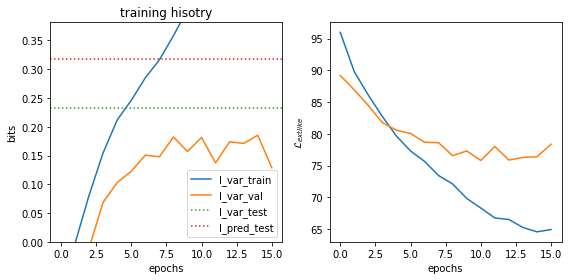

reg is 0.001
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0191 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 26ms/step - loss: 103.0796 - I_var: -0.2817 - val_loss: 95.0231 - val_I_var: -0.1263
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 92.3260 - I_var: -0.0730 - val_loss: 93.2149 - val_I_var: -0.0924
Epoch 3/1000
9/9 [==============================] - 0s 7ms/step - loss: 91.6227 - I_var: -0.0473 - val_loss: 92.0655 - val_I_var: -0.0741
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 89.2272 - I_var: -5.8475e-04 - val_loss: 89.6854 - val_I_var: -0.0104
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 86.5507 - I_var: 0.0634 - val_loss: 85.2146 - val_I_var: 0.0886
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 83.4098 - I_var: 0.1144 - val_loss: 81.6400 - val_I_var: 0.1640
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 81.0501 - I_var: 0.1647 - val_loss: 78.7210 - val_I_var: 0.2304
Epoch 8/1000
9/9 [=============================

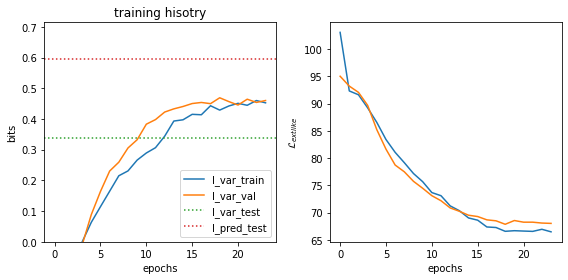

reg is 0.005
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0205 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 21ms/step - loss: 96.3961 - I_var: -0.1409 - val_loss: 95.6329 - val_I_var: -0.3369
Epoch 2/1000
9/9 [==============================] - 0s 5ms/step - loss: 90.9679 - I_var: -0.0201 - val_loss: 92.8865 - val_I_var: -0.2915
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 85.7774 - I_var: 0.0611 - val_loss: 89.1708 - val_I_var: -0.1815
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 82.1939 - I_var: 0.1448 - val_loss: 84.5855 - val_I_var: -0.0482
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 78.1800 - I_var: 0.2240 - val_loss: 82.1293 - val_I_var: 0.0339
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 75.8693 - I_var: 0.2585 - val_loss: 80.6711 - val_I_var: 0.0747
Epoch 7/1000
9/9 [==============================] - 0s 5ms/step - loss: 73.9143 - I_var: 0.3121 - val_loss: 79.5942 - val_I_var: 0.1123
Epoch 8/1000
9/9 [==============================] - 0s

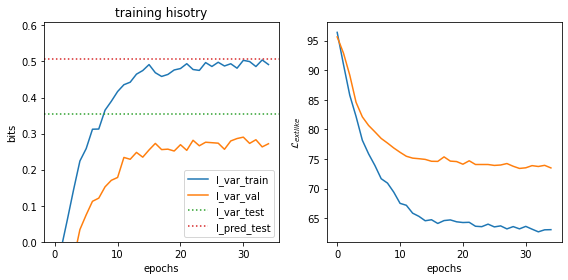

reg is 0.01
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0185 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 23ms/step - loss: 102.8594 - I_var: -0.0793 - val_loss: 90.1563 - val_I_var: 0.1579
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 97.0105 - I_var: -3.4446e-04 - val_loss: 86.6031 - val_I_var: 0.1611
Epoch 3/1000
9/9 [==============================] - 0s 7ms/step - loss: 91.8274 - I_var: 0.0519 - val_loss: 82.3983 - val_I_var: 0.2165
Epoch 4/1000
9/9 [==============================] - 0s 7ms/step - loss: 87.8814 - I_var: 0.0943 - val_loss: 80.3960 - val_I_var: 0.2005
Epoch 5/1000
9/9 [==============================] - 0s 7ms/step - loss: 85.0968 - I_var: 0.1564 - val_loss: 77.5764 - val_I_var: 0.2447
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 82.3287 - I_var: 0.1848 - val_loss: 75.5234 - val_I_var: 0.2773
Epoch 7/1000
9/9 [==============================] - 0s 7ms/step - loss: 80.7781 - I_var: 0.2407 - val_loss: 73.6001 - val_I_var: 0.3032
Epoch 8/1000
9/9 [==============================] - 0

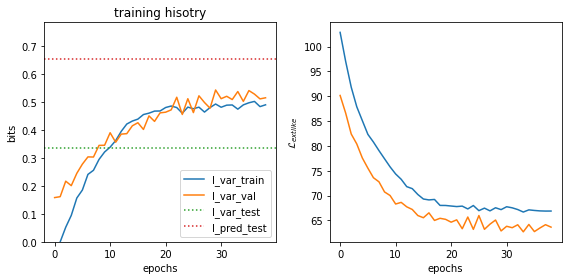

reg is 0.05
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0184 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 26ms/step - loss: 104.9877 - I_var: 0.0143 - val_loss: 98.4658 - val_I_var: 0.0376
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 94.2866 - I_var: 0.1230 - val_loss: 91.3980 - val_I_var: 0.1363
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 87.6272 - I_var: 0.1856 - val_loss: 87.0897 - val_I_var: 0.1792
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 83.0797 - I_var: 0.2135 - val_loss: 84.0764 - val_I_var: 0.2204
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 80.4387 - I_var: 0.2613 - val_loss: 81.5300 - val_I_var: 0.2559
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 77.6135 - I_var: 0.2875 - val_loss: 79.7521 - val_I_var: 0.2787
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 75.4096 - I_var: 0.3102 - val_loss: 78.0096 - val_I_var: 0.2861
Epoch 8/1000
9/9 [==============================] - 0s 6ms/

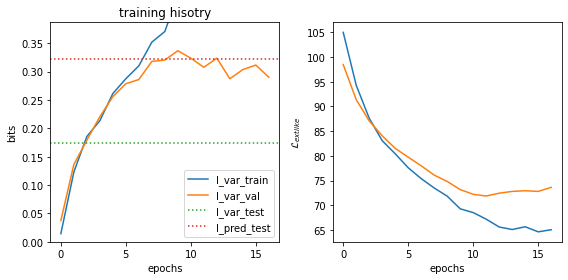

reg is 0.1
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0183 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 23ms/step - loss: 144.3156 - I_var: -0.1202 - val_loss: 122.9760 - val_I_var: 0.1100
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 118.9973 - I_var: 0.0392 - val_loss: 107.8229 - val_I_var: 0.1420
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 104.7551 - I_var: 0.0996 - val_loss: 98.4375 - val_I_var: 0.1987
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 94.0231 - I_var: 0.1917 - val_loss: 90.8778 - val_I_var: 0.2594
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 86.9171 - I_var: 0.2536 - val_loss: 86.7412 - val_I_var: 0.2944
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 82.8757 - I_var: 0.3133 - val_loss: 84.9746 - val_I_var: 0.3045
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 79.8675 - I_var: 0.3476 - val_loss: 82.7607 - val_I_var: 0.3297
Epoch 8/1000
9/9 [==============================] - 0s

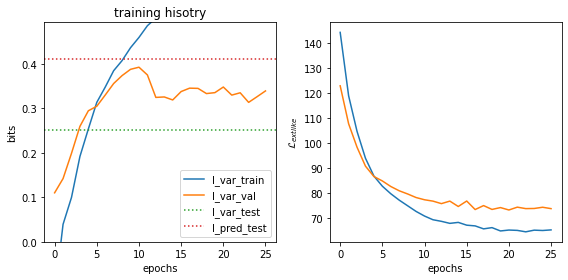

reg is 0.3
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0189 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 52ms/step - loss: 172.9065 - I_var: -0.0403 - val_loss: 153.3969 - val_I_var: -0.2961
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 139.8578 - I_var: 0.0450 - val_loss: 124.5312 - val_I_var: -0.1410
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 116.5234 - I_var: 0.1228 - val_loss: 107.9705 - val_I_var: 0.0070
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 101.4055 - I_var: 0.2133 - val_loss: 98.5822 - val_I_var: 0.1111
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 92.0341 - I_var: 0.2837 - val_loss: 93.1368 - val_I_var: 0.1350
Epoch 6/1000
9/9 [==============================] - 0s 7ms/step - loss: 85.7974 - I_var: 0.3163 - val_loss: 89.2364 - val_I_var: 0.1541
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 81.5393 - I_var: 0.3693 - val_loss: 86.3956 - val_I_var: 0.1824
Epoch 8/1000
9/9 [==============================] 

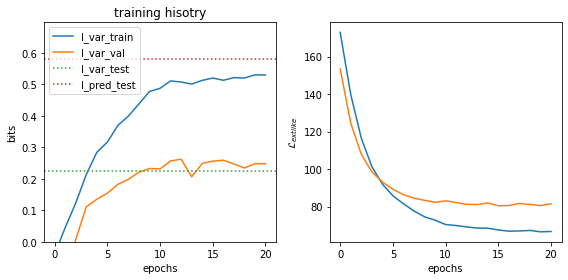

reg is 0.5
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0187 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 22ms/step - loss: 219.1178 - I_var: -0.0080 - val_loss: 177.6552 - val_I_var: 0.2642
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 166.5012 - I_var: 0.0985 - val_loss: 139.7008 - val_I_var: 0.2917
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 133.9492 - I_var: 0.1240 - val_loss: 113.8248 - val_I_var: 0.3808
Epoch 4/1000
9/9 [==============================] - 0s 7ms/step - loss: 115.5140 - I_var: 0.1416 - val_loss: 99.1473 - val_I_var: 0.4140
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 101.8505 - I_var: 0.2147 - val_loss: 89.1868 - val_I_var: 0.4590
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 93.3766 - I_var: 0.2469 - val_loss: 83.9013 - val_I_var: 0.4695
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 87.4966 - I_var: 0.2743 - val_loss: 78.9204 - val_I_var: 0.5124
Epoch 8/1000
9/9 [==============================] -

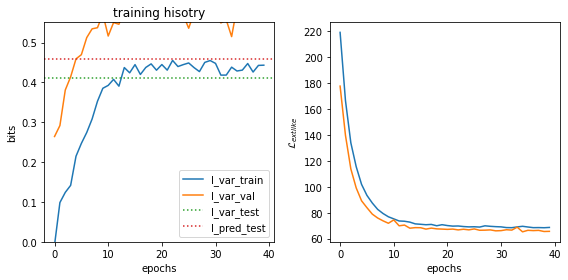

reg is 0.8
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.018 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 22ms/step - loss: 253.6681 - I_var: -0.2045 - val_loss: 207.6132 - val_I_var: -0.1201
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 189.3534 - I_var: -0.0946 - val_loss: 161.6649 - val_I_var: -0.1110
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 150.8020 - I_var: -0.0848 - val_loss: 133.9572 - val_I_var: -0.0908
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 126.0671 - I_var: -0.0381 - val_loss: 114.7640 - val_I_var: -0.0263
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 109.6006 - I_var: 0.0589 - val_loss: 102.8255 - val_I_var: 0.0466
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 97.7600 - I_var: 0.1540 - val_loss: 93.7886 - val_I_var: 0.1351
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 89.9693 - I_var: 0.2312 - val_loss: 88.2879 - val_I_var: 0.1923
Epoch 8/1000
9/9 [========================

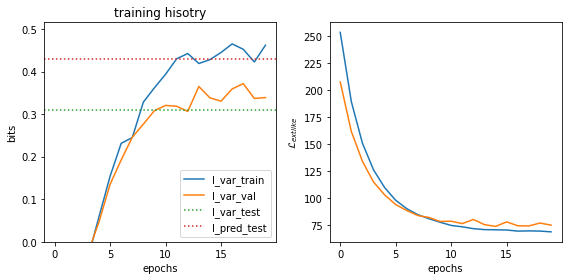

reg is 1
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.019 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 26ms/step - loss: 332.2809 - I_var: -0.0998 - val_loss: 266.8047 - val_I_var: 0.1003
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 237.6599 - I_var: -0.0131 - val_loss: 196.2980 - val_I_var: 0.1742
Epoch 3/1000
9/9 [==============================] - 0s 7ms/step - loss: 177.2764 - I_var: 0.1012 - val_loss: 152.0312 - val_I_var: 0.2440
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 140.8214 - I_var: 0.1532 - val_loss: 126.1062 - val_I_var: 0.2807
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 118.9301 - I_var: 0.2037 - val_loss: 110.0028 - val_I_var: 0.3108
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 104.3354 - I_var: 0.2367 - val_loss: 99.5032 - val_I_var: 0.3495
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 94.5416 - I_var: 0.2984 - val_loss: 92.8683 - val_I_var: 0.3715
Epoch 8/1000
9/9 [=============================

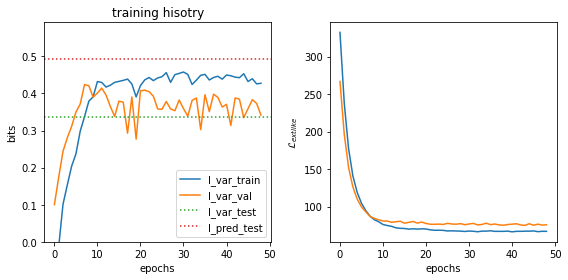

reg is 1.5
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0203 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 25ms/step - loss: 418.8998 - I_var: -0.2754 - val_loss: 329.3712 - val_I_var: 0.0207
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 290.2955 - I_var: -0.1016 - val_loss: 237.1194 - val_I_var: 0.0311
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 214.5437 - I_var: -0.1009 - val_loss: 180.8756 - val_I_var: 0.0419
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 168.5444 - I_var: -0.0929 - val_loss: 146.3649 - val_I_var: 0.0692
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 140.0392 - I_var: -0.0586 - val_loss: 123.9744 - val_I_var: 0.1177
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 120.2423 - I_var: 0.0223 - val_loss: 107.4270 - val_I_var: 0.1954
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 105.9436 - I_var: 0.1274 - val_loss: 97.4122 - val_I_var: 0.2185
Epoch 8/1000
9/9 [========================

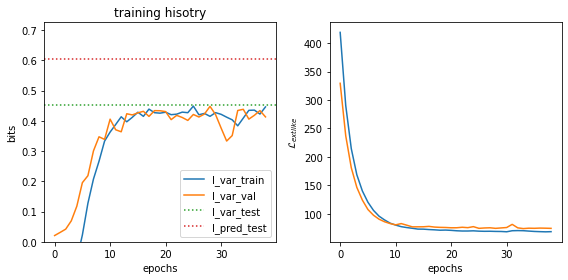

reg is 2
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.019 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 22ms/step - loss: 97.8354 - I_var: -0.1871 - val_loss: 87.2191 - val_I_var: 0.0121
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 92.7000 - I_var: -0.0827 - val_loss: 86.2228 - val_I_var: 0.0310
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 90.1676 - I_var: -0.0225 - val_loss: 85.3628 - val_I_var: 0.0622
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 86.7979 - I_var: 0.0403 - val_loss: 81.6568 - val_I_var: 0.1651
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 82.7450 - I_var: 0.1443 - val_loss: 78.9216 - val_I_var: 0.2498
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 79.2332 - I_var: 0.2089 - val_loss: 77.1751 - val_I_var: 0.3148
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 76.9949 - I_var: 0.2687 - val_loss: 75.0595 - val_I_var: 0.3640
Epoch 8/1000
9/9 [==============================] - 0s 6m

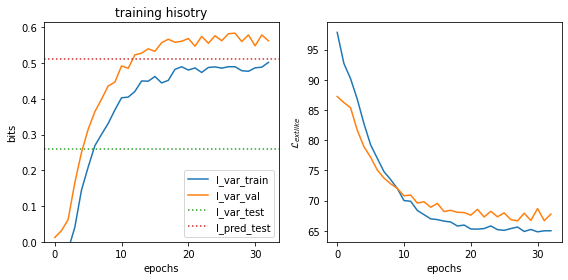

reg is 0.0001
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.018 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 22ms/step - loss: 100.2937 - I_var: -0.1858 - val_loss: 93.4105 - val_I_var: -0.1174
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 92.5265 - I_var: -0.0266 - val_loss: 93.0612 - val_I_var: -0.1263
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 91.4017 - I_var: -0.0375 - val_loss: 92.0075 - val_I_var: -0.0998
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 90.7657 - I_var: 0.0035 - val_loss: 89.0472 - val_I_var: -0.0104
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 87.8782 - I_var: 0.0423 - val_loss: 85.7153 - val_I_var: 0.0544
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 84.2893 - I_var: 0.1368 - val_loss: 81.6434 - val_I_var: 0.1509
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 79.6832 - I_var: 0.2329 - val_loss: 80.0508 - val_I_var: 0.1631
Epoch 8/1000
9/9 [==============================] - 

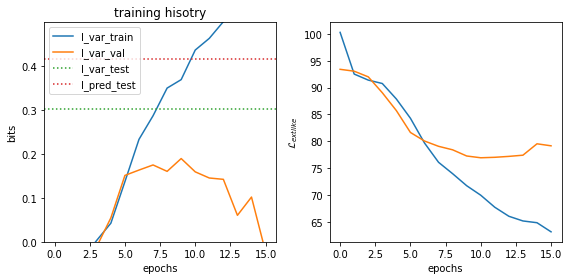

reg is 0.0005
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0188 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 23ms/step - loss: 97.8684 - I_var: -0.1500 - val_loss: 89.4380 - val_I_var: 0.0303
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 92.9536 - I_var: -0.0558 - val_loss: 88.6570 - val_I_var: 0.0395
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 91.1130 - I_var: -0.0195 - val_loss: 87.5734 - val_I_var: 0.0361
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 89.2154 - I_var: 0.0226 - val_loss: 85.2894 - val_I_var: 0.0774
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 86.1001 - I_var: 0.0928 - val_loss: 82.0016 - val_I_var: 0.1215
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 82.4872 - I_var: 0.1591 - val_loss: 77.5546 - val_I_var: 0.2053
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 79.4221 - I_var: 0.2191 - val_loss: 73.1088 - val_I_var: 0.3047
Epoch 8/1000
9/9 [==============================] - 0s 6m

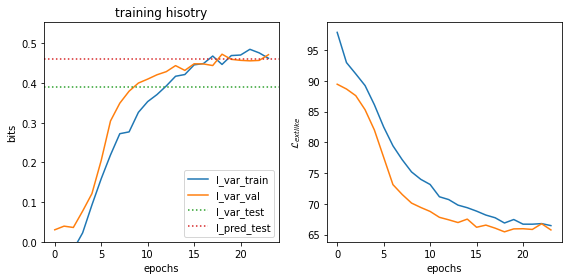

reg is 0.001
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0175 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 22ms/step - loss: 92.7118 - I_var: -0.0351 - val_loss: 87.4639 - val_I_var: -0.0499
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 88.4797 - I_var: 0.0559 - val_loss: 80.8685 - val_I_var: 0.1523
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 84.2419 - I_var: 0.1313 - val_loss: 79.1175 - val_I_var: 0.2005
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 81.1789 - I_var: 0.1854 - val_loss: 76.9402 - val_I_var: 0.2615
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 79.0817 - I_var: 0.2432 - val_loss: 75.9555 - val_I_var: 0.2599
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 76.8516 - I_var: 0.2632 - val_loss: 75.2252 - val_I_var: 0.2862
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 75.5280 - I_var: 0.3029 - val_loss: 74.3242 - val_I_var: 0.2901
Epoch 8/1000
9/9 [==============================] - 0s 6ms

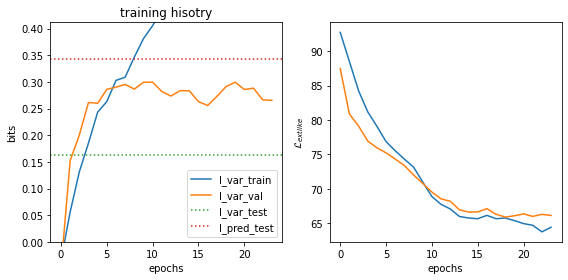

reg is 0.005
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.019 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 23ms/step - loss: 97.3643 - I_var: -0.1044 - val_loss: 85.8929 - val_I_var: -0.0683
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 91.3964 - I_var: 0.0250 - val_loss: 82.6241 - val_I_var: 0.0102
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 87.8290 - I_var: 0.0984 - val_loss: 78.4952 - val_I_var: 0.1426
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 83.5759 - I_var: 0.1621 - val_loss: 76.0030 - val_I_var: 0.1667
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 80.9236 - I_var: 0.2283 - val_loss: 74.3948 - val_I_var: 0.1965
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 78.2439 - I_var: 0.2576 - val_loss: 73.6240 - val_I_var: 0.2048
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 76.2997 - I_var: 0.3063 - val_loss: 72.4881 - val_I_var: 0.2036
Epoch 8/1000
9/9 [==============================] - 0s 6ms

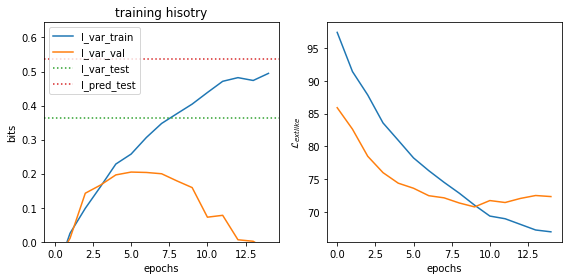

reg is 0.01
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0183 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 23ms/step - loss: 103.0488 - I_var: -0.1039 - val_loss: 86.9398 - val_I_var: 0.2115
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 94.9792 - I_var: -0.0017 - val_loss: 81.8437 - val_I_var: 0.2978
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 89.2838 - I_var: 0.0857 - val_loss: 79.6593 - val_I_var: 0.3214
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 84.8830 - I_var: 0.1621 - val_loss: 75.7316 - val_I_var: 0.3901
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 81.5556 - I_var: 0.2096 - val_loss: 75.6386 - val_I_var: 0.3927
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 78.9969 - I_var: 0.2536 - val_loss: 73.0396 - val_I_var: 0.4479
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 77.0629 - I_var: 0.2818 - val_loss: 72.2983 - val_I_var: 0.4621
Epoch 8/1000
9/9 [==============================] - 0s 6m

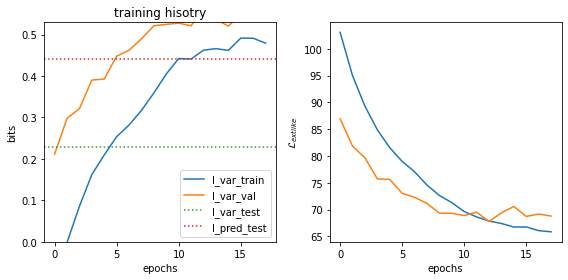

reg is 0.05
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0199 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 25ms/step - loss: 113.6144 - I_var: -0.1383 - val_loss: 102.8249 - val_I_var: -0.1775
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 102.7293 - I_var: -0.0425 - val_loss: 97.4541 - val_I_var: -0.1708
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 97.2145 - I_var: -0.0326 - val_loss: 93.6705 - val_I_var: -0.1435
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 93.2917 - I_var: 0.0105 - val_loss: 89.0103 - val_I_var: -0.0994
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 88.6057 - I_var: 0.0839 - val_loss: 85.0035 - val_I_var: -0.0470
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 84.0632 - I_var: 0.1483 - val_loss: 82.5229 - val_I_var: -0.0068
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 81.3913 - I_var: 0.2084 - val_loss: 80.1375 - val_I_var: 0.0279
Epoch 8/1000
9/9 [==============================

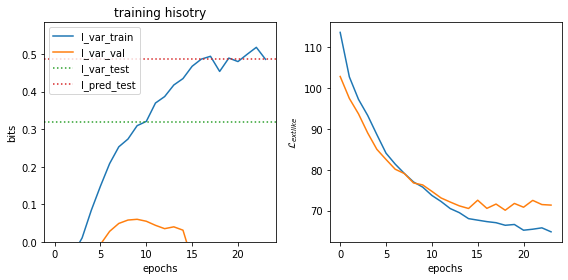

reg is 0.1
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0217 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 22ms/step - loss: 145.8761 - I_var: -0.1735 - val_loss: 124.0896 - val_I_var: -0.3316
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 122.4328 - I_var: -0.0642 - val_loss: 109.7555 - val_I_var: -0.3206
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 110.2054 - I_var: -0.0657 - val_loss: 100.8107 - val_I_var: -0.3250
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 102.3875 - I_var: -0.0418 - val_loss: 94.3668 - val_I_var: -0.2904
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 95.9000 - I_var: 0.0406 - val_loss: 86.7751 - val_I_var: -0.1339
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 87.1410 - I_var: 0.1534 - val_loss: 80.1412 - val_I_var: 0.0956
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 82.4844 - I_var: 0.2322 - val_loss: 76.0867 - val_I_var: 0.1461
Epoch 8/1000
9/9 [==========================

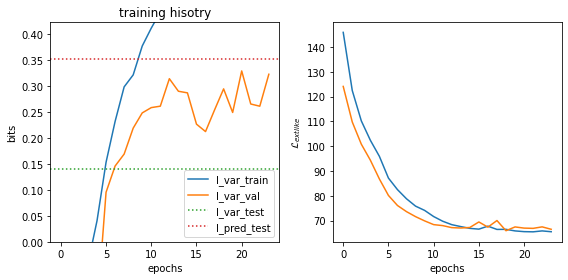

reg is 0.3
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0181 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 20ms/step - loss: 173.1460 - I_var: -0.0380 - val_loss: 147.6238 - val_I_var: -0.1235
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 137.9175 - I_var: 0.0627 - val_loss: 122.3520 - val_I_var: -0.0355
Epoch 3/1000
9/9 [==============================] - 0s 5ms/step - loss: 115.4517 - I_var: 0.1576 - val_loss: 106.7207 - val_I_var: 0.0394
Epoch 4/1000
9/9 [==============================] - 0s 5ms/step - loss: 100.6837 - I_var: 0.2367 - val_loss: 94.8353 - val_I_var: 0.0907
Epoch 5/1000
9/9 [==============================] - 0s 5ms/step - loss: 90.9120 - I_var: 0.2944 - val_loss: 89.1990 - val_I_var: 0.1244
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 85.1504 - I_var: 0.3452 - val_loss: 84.3374 - val_I_var: 0.1701
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 80.2088 - I_var: 0.4052 - val_loss: 81.6419 - val_I_var: 0.1831
Epoch 8/1000
9/9 [==============================] 

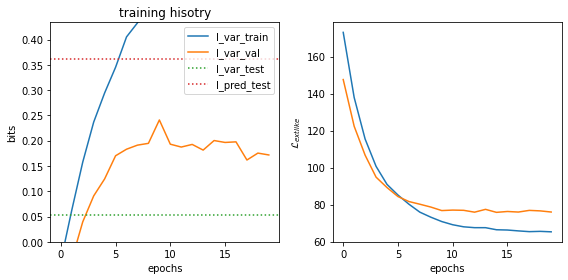

reg is 0.5
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0207 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 24ms/step - loss: 225.9573 - I_var: -0.3707 - val_loss: 182.3605 - val_I_var: -0.3316
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 167.8761 - I_var: -0.1406 - val_loss: 145.8177 - val_I_var: -0.3138
Epoch 3/1000
9/9 [==============================] - 0s 7ms/step - loss: 138.6230 - I_var: -0.1251 - val_loss: 124.0288 - val_I_var: -0.3129
Epoch 4/1000
9/9 [==============================] - 0s 7ms/step - loss: 120.8377 - I_var: -0.1255 - val_loss: 110.9622 - val_I_var: -0.3143
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 110.3458 - I_var: -0.1182 - val_loss: 103.0775 - val_I_var: -0.3158
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 103.2567 - I_var: -0.1383 - val_loss: 98.2049 - val_I_var: -0.3194
Epoch 7/1000
9/9 [==============================] - 0s 7ms/step - loss: 99.5925 - I_var: -0.1228 - val_loss: 95.0657 - val_I_var: -0.3200
Epoch 8/1000
9/9 [=================

/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


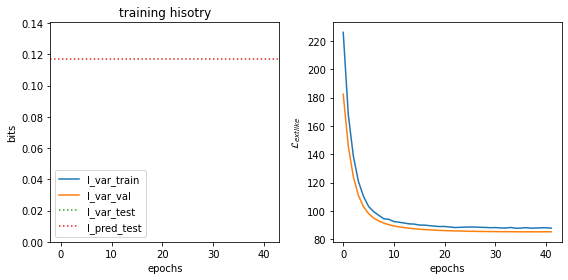

reg is 0.8
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0173 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 23ms/step - loss: 249.0485 - I_var: -0.1080 - val_loss: 202.4325 - val_I_var: -0.0932
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 187.0522 - I_var: -0.0466 - val_loss: 157.1921 - val_I_var: -0.0880
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 148.0372 - I_var: -0.0343 - val_loss: 129.6882 - val_I_var: -0.0870
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 124.1631 - I_var: 0.0453 - val_loss: 110.5533 - val_I_var: 0.0026
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 106.8877 - I_var: 0.1605 - val_loss: 96.9590 - val_I_var: 0.1454
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 95.7630 - I_var: 0.2390 - val_loss: 89.3079 - val_I_var: 0.2074
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 89.0457 - I_var: 0.2877 - val_loss: 84.4375 - val_I_var: 0.2310
Epoch 8/1000
9/9 [===========================

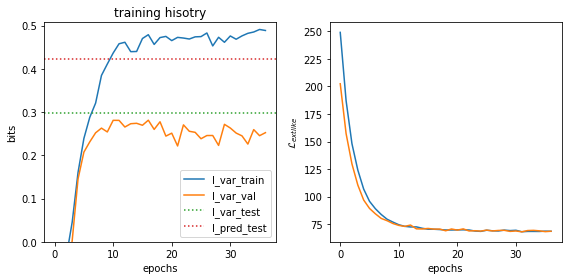

reg is 1
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0191 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 22ms/step - loss: 327.4823 - I_var: -0.0923 - val_loss: 269.6054 - val_I_var: 0.0398
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 234.1848 - I_var: -0.0020 - val_loss: 199.0601 - val_I_var: 0.0884
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 175.9025 - I_var: 0.0590 - val_loss: 154.2014 - val_I_var: 0.1714
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 139.2284 - I_var: 0.1132 - val_loss: 127.2042 - val_I_var: 0.2394
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 117.6200 - I_var: 0.2062 - val_loss: 110.7448 - val_I_var: 0.2810
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 103.0882 - I_var: 0.2549 - val_loss: 101.6739 - val_I_var: 0.2964
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 92.7133 - I_var: 0.3029 - val_loss: 94.8572 - val_I_var: 0.3205
Epoch 8/1000
9/9 [============================

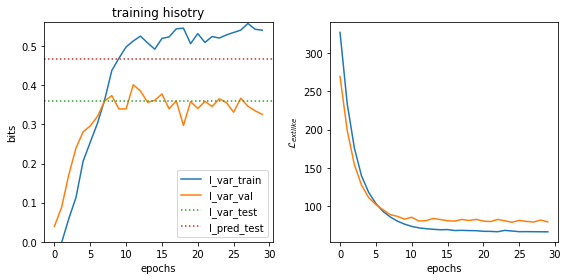

reg is 1.5
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0193 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 22ms/step - loss: 400.6468 - I_var: -0.0595 - val_loss: 318.8317 - val_I_var: -0.1118
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 276.9797 - I_var: 0.0064 - val_loss: 225.9125 - val_I_var: -0.0980
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 199.7055 - I_var: 0.0972 - val_loss: 168.7819 - val_I_var: -0.0355
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 152.3466 - I_var: 0.1696 - val_loss: 134.1864 - val_I_var: 0.0373
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 124.3586 - I_var: 0.2429 - val_loss: 113.4282 - val_I_var: 0.0832
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 106.7286 - I_var: 0.2970 - val_loss: 99.4563 - val_I_var: 0.1593
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 94.9491 - I_var: 0.3392 - val_loss: 90.4736 - val_I_var: 0.2168
Epoch 8/1000
9/9 [===========================

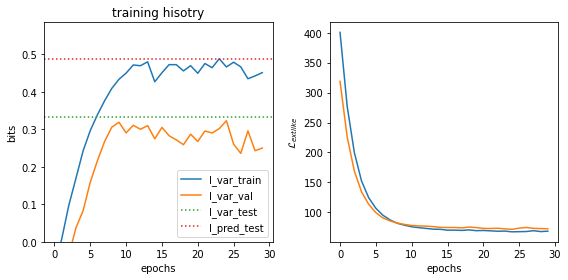

reg is 2
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0187 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 29ms/step - loss: 95.9054 - I_var: -0.0884 - val_loss: 87.3128 - val_I_var: -0.2423
Epoch 2/1000
9/9 [==============================] - 0s 8ms/step - loss: 91.2747 - I_var: 0.0064 - val_loss: 85.9153 - val_I_var: -0.2536
Epoch 3/1000
9/9 [==============================] - 0s 7ms/step - loss: 87.6948 - I_var: 0.0701 - val_loss: 85.2480 - val_I_var: -0.3164
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 83.6621 - I_var: 0.1503 - val_loss: 80.5059 - val_I_var: -0.2032
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 80.3045 - I_var: 0.2264 - val_loss: 78.0361 - val_I_var: -0.1721
Epoch 6/1000
9/9 [==============================] - 0s 7ms/step - loss: 77.6034 - I_var: 0.2711 - val_loss: 75.7705 - val_I_var: -0.1241
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 75.3370 - I_var: 0.3075 - val_loss: 74.6926 - val_I_var: -0.0897
Epoch 8/1000
9/9 [==============================] - 

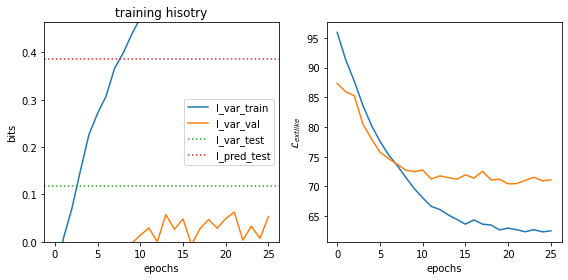

reg is 0.0001
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0168 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 21ms/step - loss: 107.4497 - I_var: -0.3948 - val_loss: 90.5115 - val_I_var: -0.2068
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 93.4471 - I_var: -0.0984 - val_loss: 89.5537 - val_I_var: -0.1792
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 91.9891 - I_var: -0.0993 - val_loss: 89.0202 - val_I_var: -0.1719
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 91.6893 - I_var: -0.0781 - val_loss: 88.5348 - val_I_var: -0.1679
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 90.8326 - I_var: -0.0702 - val_loss: 86.4445 - val_I_var: -0.1432
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 87.7129 - I_var: -0.0342 - val_loss: 83.6675 - val_I_var: -0.1004
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 82.6546 - I_var: 0.0834 - val_loss: 84.3752 - val_I_var: -0.1030
Epoch 8/1000
9/9 [============================

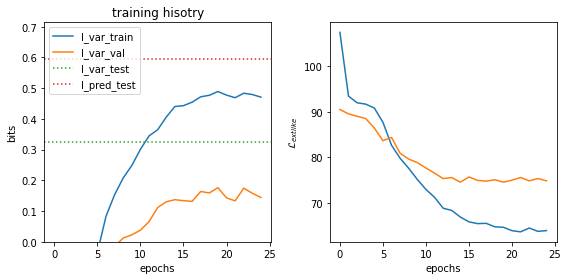

reg is 0.0005
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.017 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 20ms/step - loss: 108.7170 - I_var: -0.4035 - val_loss: 92.0090 - val_I_var: -0.0351
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 93.7094 - I_var: -0.0807 - val_loss: 89.3696 - val_I_var: 0.0198
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 92.6212 - I_var: -0.0672 - val_loss: 88.7775 - val_I_var: 0.0264
Epoch 4/1000
9/9 [==============================] - 0s 5ms/step - loss: 91.6549 - I_var: -0.0652 - val_loss: 88.8492 - val_I_var: 0.0187
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 89.7915 - I_var: -0.0071 - val_loss: 87.8675 - val_I_var: 0.0368
Epoch 6/1000
9/9 [==============================] - 0s 5ms/step - loss: 86.4479 - I_var: 0.0483 - val_loss: 85.1233 - val_I_var: 0.0954
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 82.8456 - I_var: 0.1246 - val_loss: 82.0272 - val_I_var: 0.1562
Epoch 8/1000
9/9 [==============================] - 0

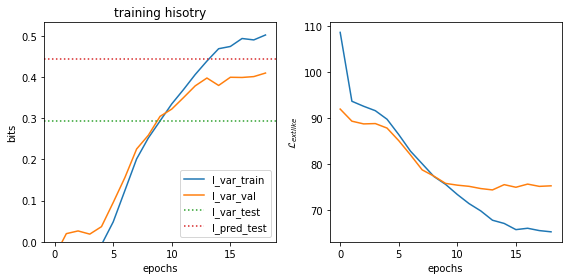

reg is 0.001
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0163 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 20ms/step - loss: 97.9995 - I_var: -0.1423 - val_loss: 86.7483 - val_I_var: -0.1166
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 93.7120 - I_var: -0.0553 - val_loss: 85.0857 - val_I_var: -0.0803
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 91.0893 - I_var: -0.0052 - val_loss: 81.9175 - val_I_var: 0.0289
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 87.2750 - I_var: 0.0704 - val_loss: 79.0728 - val_I_var: 0.0968
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 83.4863 - I_var: 0.1455 - val_loss: 77.2966 - val_I_var: 0.1500
Epoch 6/1000
9/9 [==============================] - 0s 8ms/step - loss: 80.7836 - I_var: 0.2037 - val_loss: 76.1686 - val_I_var: 0.1779
Epoch 7/1000
9/9 [==============================] - 0s 7ms/step - loss: 78.6109 - I_var: 0.2476 - val_loss: 75.5977 - val_I_var: 0.1911
Epoch 8/1000
9/9 [==============================] - 0s 

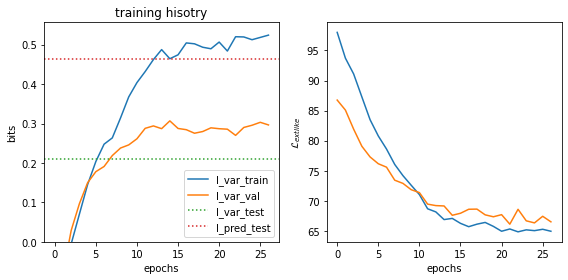

reg is 0.005
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0174 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 22ms/step - loss: 93.1894 - I_var: -0.0333 - val_loss: 95.5645 - val_I_var: -0.0630
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 88.8079 - I_var: 0.0397 - val_loss: 88.0585 - val_I_var: 0.0274
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 83.5500 - I_var: 0.1436 - val_loss: 83.4274 - val_I_var: 0.1413
Epoch 4/1000
9/9 [==============================] - 0s 5ms/step - loss: 80.4892 - I_var: 0.2026 - val_loss: 79.1828 - val_I_var: 0.2344
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 78.6876 - I_var: 0.2570 - val_loss: 78.5548 - val_I_var: 0.2436
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 76.2889 - I_var: 0.2831 - val_loss: 75.9807 - val_I_var: 0.2804
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 74.6963 - I_var: 0.3202 - val_loss: 75.9229 - val_I_var: 0.2762
Epoch 8/1000
9/9 [==============================] - 0s 5ms

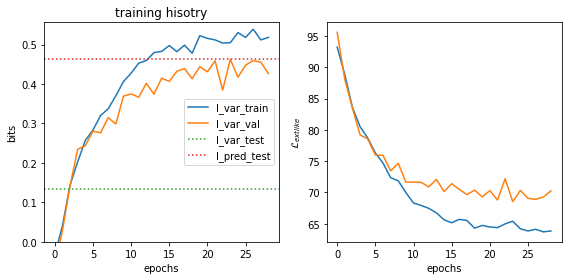

reg is 0.01
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0176 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 22ms/step - loss: 105.0517 - I_var: -0.1644 - val_loss: 92.7607 - val_I_var: 0.0280
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 98.1370 - I_var: -0.0680 - val_loss: 88.9470 - val_I_var: 0.0511
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 93.1125 - I_var: -0.0295 - val_loss: 84.7020 - val_I_var: 0.0716
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 89.2541 - I_var: 0.0552 - val_loss: 79.9909 - val_I_var: 0.1326
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 85.1806 - I_var: 0.1258 - val_loss: 76.7539 - val_I_var: 0.1396
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 82.6144 - I_var: 0.1604 - val_loss: 74.8694 - val_I_var: 0.1513
Epoch 7/1000
9/9 [==============================] - 0s 5ms/step - loss: 80.9248 - I_var: 0.1923 - val_loss: 73.0819 - val_I_var: 0.1785
Epoch 8/1000
9/9 [==============================] - 0s 6

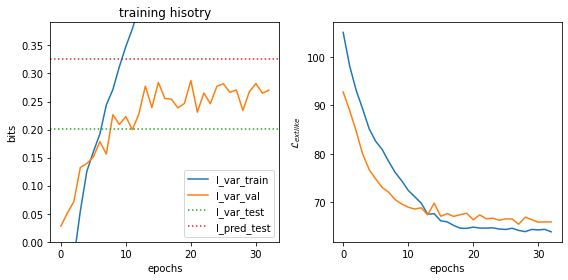

reg is 0.05
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0196 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 23ms/step - loss: 116.7312 - I_var: -0.2356 - val_loss: 100.2256 - val_I_var: -0.0482
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 104.3707 - I_var: -0.0931 - val_loss: 94.8513 - val_I_var: -0.0402
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 99.4517 - I_var: -0.0817 - val_loss: 90.5332 - val_I_var: -0.0111
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 95.0249 - I_var: -0.0513 - val_loss: 85.6334 - val_I_var: 0.0570
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 91.2389 - I_var: 0.0128 - val_loss: 81.6631 - val_I_var: 0.1239
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 86.4516 - I_var: 0.0814 - val_loss: 78.3353 - val_I_var: 0.2052
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 83.0557 - I_var: 0.1524 - val_loss: 75.7571 - val_I_var: 0.2677
Epoch 8/1000
9/9 [==============================] 

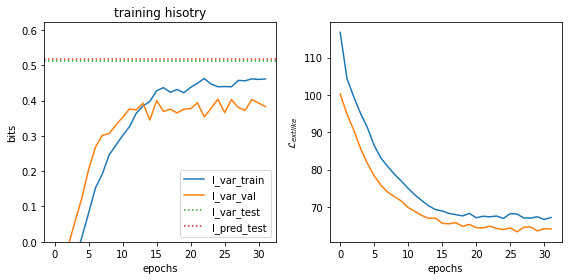

reg is 0.1
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0185 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 21ms/step - loss: 147.3514 - I_var: -0.2346 - val_loss: 125.3160 - val_I_var: -0.1111
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 122.3881 - I_var: -0.0927 - val_loss: 110.5358 - val_I_var: -0.0973
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 107.8164 - I_var: -0.0316 - val_loss: 97.9056 - val_I_var: 0.0132
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 96.5434 - I_var: 0.0713 - val_loss: 88.3636 - val_I_var: 0.0838
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 89.3923 - I_var: 0.1570 - val_loss: 82.2809 - val_I_var: 0.1307
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 84.0105 - I_var: 0.2013 - val_loss: 78.5706 - val_I_var: 0.1469
Epoch 7/1000
9/9 [==============================] - 0s 5ms/step - loss: 80.6579 - I_var: 0.2513 - val_loss: 75.6571 - val_I_var: 0.1667
Epoch 8/1000
9/9 [==============================] 

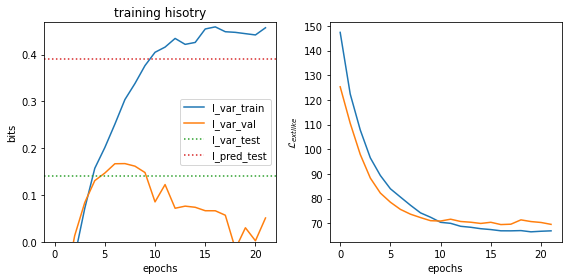

reg is 0.3
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0229 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 23ms/step - loss: 177.2171 - I_var: -0.1486 - val_loss: 151.2550 - val_I_var: -0.2229
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 140.6883 - I_var: -0.0518 - val_loss: 127.8538 - val_I_var: -0.2097
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 121.8077 - I_var: -0.0323 - val_loss: 112.9307 - val_I_var: -0.1963
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 108.1697 - I_var: 0.0404 - val_loss: 100.9580 - val_I_var: -0.0917
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 96.6325 - I_var: 0.1479 - val_loss: 91.6576 - val_I_var: 0.0664
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 88.4869 - I_var: 0.2425 - val_loss: 87.8854 - val_I_var: 0.1095
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 83.4448 - I_var: 0.2957 - val_loss: 84.9078 - val_I_var: 0.1315
Epoch 8/1000
9/9 [===========================

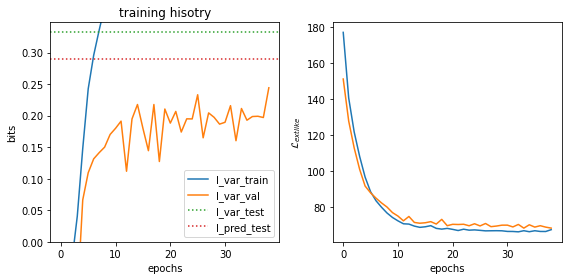

reg is 0.5
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0208 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 27ms/step - loss: 225.5206 - I_var: -0.1701 - val_loss: 187.3504 - val_I_var: -0.2214
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 172.2573 - I_var: -0.0541 - val_loss: 150.6386 - val_I_var: -0.2123
Epoch 3/1000
9/9 [==============================] - 0s 7ms/step - loss: 141.6821 - I_var: -0.0621 - val_loss: 126.9844 - val_I_var: -0.2488
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 122.0171 - I_var: -0.0263 - val_loss: 111.8369 - val_I_var: -0.2345
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 109.2645 - I_var: 0.0320 - val_loss: 100.2098 - val_I_var: -0.1956
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 99.0187 - I_var: 0.1083 - val_loss: 90.6588 - val_I_var: -0.1004
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 90.8971 - I_var: 0.2069 - val_loss: 83.8651 - val_I_var: 0.0615
Epoch 8/1000
9/9 [======================

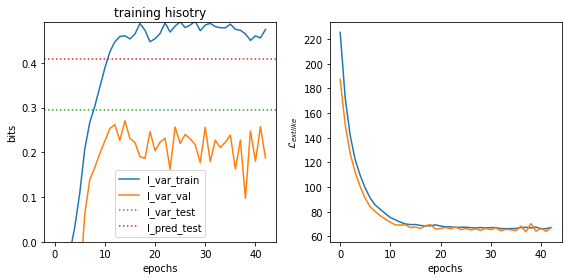

reg is 0.8
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0215 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 22ms/step - loss: 250.9977 - I_var: -0.0467 - val_loss: 202.4926 - val_I_var: -0.1654
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 186.2340 - I_var: 0.0581 - val_loss: 154.6430 - val_I_var: 0.0219
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 145.3499 - I_var: 0.1203 - val_loss: 123.9648 - val_I_var: 0.0631
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 120.9952 - I_var: 0.1899 - val_loss: 105.3349 - val_I_var: 0.0694
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 104.9664 - I_var: 0.2360 - val_loss: 93.9446 - val_I_var: 0.1112
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 95.0852 - I_var: 0.2809 - val_loss: 86.0964 - val_I_var: 0.1393
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 88.2567 - I_var: 0.3089 - val_loss: 80.5968 - val_I_var: 0.1813
Epoch 8/1000
9/9 [==============================]

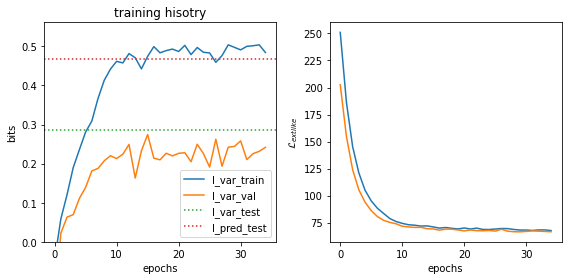

reg is 1
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0163 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 20ms/step - loss: 324.0925 - I_var: -0.0504 - val_loss: 258.6987 - val_I_var: -0.0650
Epoch 2/1000
9/9 [==============================] - 0s 5ms/step - loss: 230.4062 - I_var: 0.0679 - val_loss: 188.9342 - val_I_var: 0.0295
Epoch 3/1000
9/9 [==============================] - 0s 5ms/step - loss: 171.4393 - I_var: 0.1443 - val_loss: 145.0325 - val_I_var: 0.1041
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 135.9625 - I_var: 0.2025 - val_loss: 121.5990 - val_I_var: 0.1466
Epoch 5/1000
9/9 [==============================] - 0s 5ms/step - loss: 114.8132 - I_var: 0.2343 - val_loss: 103.4673 - val_I_var: 0.1785
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 101.4454 - I_var: 0.2755 - val_loss: 95.3417 - val_I_var: 0.2100
Epoch 7/1000
9/9 [==============================] - 0s 5ms/step - loss: 92.6026 - I_var: 0.2919 - val_loss: 86.5643 - val_I_var: 0.2369
Epoch 8/1000
9/9 [=============================

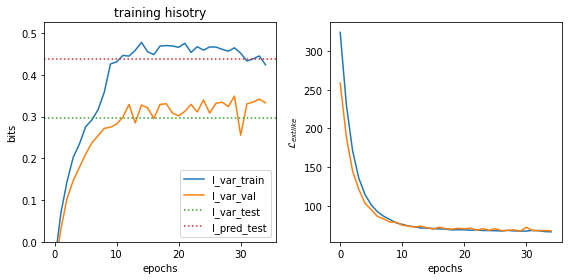

reg is 1.5
N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0166 sec.
Epoch 1/1000


<ipython-input-4-f7500d8fc2f3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


9/9 [==============================] - 0s 19ms/step - loss: 411.3908 - I_var: -0.1346 - val_loss: 334.6289 - val_I_var: -0.2430
Epoch 2/1000
9/9 [==============================] - 0s 5ms/step - loss: 286.6073 - I_var: -0.0451 - val_loss: 241.7368 - val_I_var: -0.2280
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 210.6431 - I_var: -0.0330 - val_loss: 186.4872 - val_I_var: -0.2467
Epoch 4/1000
9/9 [==============================] - 0s 5ms/step - loss: 163.5442 - I_var: 0.0188 - val_loss: 148.8093 - val_I_var: -0.1457
Epoch 5/1000
9/9 [==============================] - 0s 5ms/step - loss: 130.4959 - I_var: 0.1512 - val_loss: 121.6259 - val_I_var: 0.0153
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 110.8536 - I_var: 0.2260 - val_loss: 107.3484 - val_I_var: 0.0554
Epoch 7/1000
9/9 [==============================] - 0s 5ms/step - loss: 99.0947 - I_var: 0.2861 - val_loss: 99.2546 - val_I_var: 0.0755
Epoch 8/1000
9/9 [=======================

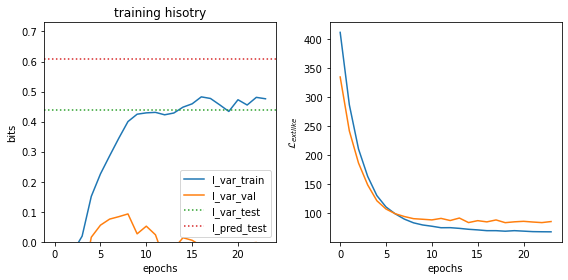

reg is 2


In [5]:
#Find the best regularization
reg_ls=[1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,3e-1,5e-1,8e-1,1,1.5,2]
R2=np.zeros((13,5))
Var=np.zeros((13,5))
Random_test_set=ProduceAA(100,7)
for rep in range(5):
    for reg in reg_ls:
        train_set, test_set = LoadData('../result/NA_compile_results.tsv','HK68') 
        Rsq,Y_var,Y_random_var = Train_model(train_set,test_set,Random_test_set,reg)
        index = reg_ls.index(reg)
        R2[index,rep]=Rsq
        Var[index,rep]=Y_var
        print('reg is',reg)

In [55]:
#Find the best regularization
reg_ls=[1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,3e-1,5e-1,8e-1,1,1.5,2,1e3]
R2=np.zeros((14,5))
Var=np.zeros((14,5))
Random_test_set=ProduceAA(100,7)
for rep in range(5):
    for reg in reg_ls:
        train_set, test_set = LoadData('../result/NA_compile_results.tsv','Bei89') 
        Rsq,Y_var = Train_model(train_set,test_set,Random_test_set,reg)
        index = reg_ls.index(reg)
        R2[index,rep]=Rsq
        Var[index,rep]=Y_var
        print('reg is',reg)

<ipython-input-54-4c0faa0b6d2b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0176 sec.
Epoch 1/1000
9/9 [==============================] - 0s 21ms/step - loss: 94.2732 - I_var: -0.2407 - val_loss: 84.7807 - val_I_var: -0.0359
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 85.3909 - I_var: -0.0320 - val_loss: 72.2559 - val_I_var: 0.1939
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 75.1896 - I_var: 0.1881 - val_loss: 65.4437 - val_I_var: 0.2968
Epoch 4/1000
9/9 [==============================] - 0s 7ms/step - loss: 66.6657 - I_var: 0.3733 - val_loss: 60.5527 - val_I_var: 0.3940
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 61.9053 - I_var: 0.4799 - val_loss: 56.9364 - val_I_var: 0.4383
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 57.6477 - I_var: 0.5627 - val_loss: 53.2307 - val_I_var: 0.5097
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step 

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 100 and the array at index 1 has size 173

[0.05152046 0.04239955 0.05519515 0.04895508 0.03760299 0.06160347
 0.06357862 0.0494656  0.05295213        nan 0.04133156 0.04101717
 0.06339746]


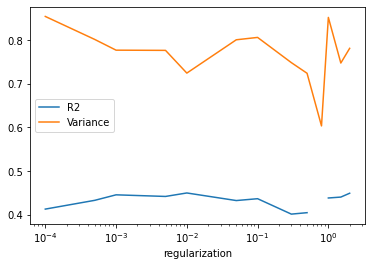

In [6]:
#print(R2)
R2_std=np.std(R2, axis=1)
print(R2_std)
R2_mean = np.average(R2, axis=1)
Var_mean = np.average(Var, axis=1)
plt.plot(reg_ls,R2_mean,label='R2')
plt.plot(reg_ls,Var_mean,label='Variance')
plt.xscale("log")
plt.xlabel("regularization")
plt.legend()

We can plot the GE nonlinearity $g(\phi)$ by creating a grid of $\phi$ values and mapping these to $\hat{y}$ values using `model.phi_to_yhat()`. We can plot confidence intervals of $p(y|\hat{y})$ using the function `model.yhat_to_yq()`.

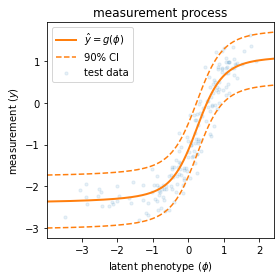

In [120]:
# Predict latent phentoype values (phi) on test data
phi_test = model.x_to_phi(x_test)

# Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 90% CI for each yhat
q = [0.05, 0.95] #[0.16, 0.84]
yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi_test, y_test, color='C0', s=10, alpha=.1, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='90% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

We can visualize the parameters of the G-P map by calling `mavenn.heatmap`

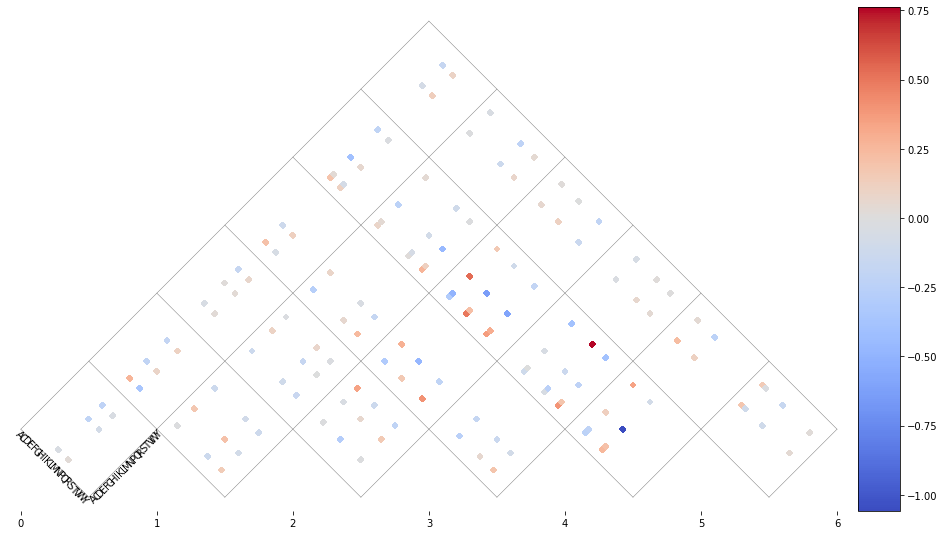

In [121]:
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10]) 
         
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);

In [122]:
#epi_map export
data = theta['theta_lclc']


def array2df(input):
    colnames=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    epi_map=pd.DataFrame()
    for i in range(7):
        for j in range(7):
            map = input[i,:,j,:]
            map_df = pd.DataFrame(map,index=colnames,columns=colnames)
            map_df['L1']=[i+1]*20
            map_df['L2']=[j+1]*20
            epi_map = epi_map.append(map_df)
    return epi_map
                
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
#print(epi_map)
#reformat the dataframe to L1,L2,aa1,aa2,epi
def df2epimap(input):
    epi_df = pd.DataFrame(columns=["L1","L2","AA1","AA2","EPI"])
    for row_index, row in input.iterrows():
        L1=row['L1']
        L2=row['L2']
        AA1=row_index
        row=row.dropna()
        row=row.drop(labels=['L1', 'L2'])
        for col_index, col in row.items():               
            EPI=col
            AA2=col_index
            add_row = [L1,L2,AA1,AA2,EPI]
            add_series = pd.Series(add_row, index = epi_df.columns)
            epi_df = epi_df.append(add_series,ignore_index=True)
    return epi_df
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/Bei_epi_64_005-0.1.csv')
print(epi_df)

      L1   L2 AA1 AA2       EPI
0    1.0  2.0   K   D -0.039591
1    1.0  2.0   K   N -0.209668
2    1.0  2.0   K   S -0.215196
3    1.0  2.0   N   D  0.028395
4    1.0  2.0   N   N -0.078027
..   ...  ...  ..  ..       ...
148  6.0  7.0   E   S -0.020657
149  6.0  7.0   K   L -0.103578
150  6.0  7.0   K   S -0.165075
151  6.0  7.0   T   L  0.041387
152  6.0  7.0   T   S  0.023373

[153 rows x 5 columns]
